In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

## Data Splitting

In [211]:
df = pd.read_excel('../data/final_dataset.xlsx')

#### Splitting data into grouped positions (defenders, midfielders, attackers)

In [233]:
def getAttackers():
    positionToFilter = ['Attack - Centre-Forward', 'Attack - Left Winger', 'Attack - Right Winger', 'Attack - Second Striker']
    filtered_df = df[df['Position'].isin(positionToFilter)]
    return filtered_df

def getMidfielders():
    positionToFilter = ['midfield - Central Midfield', 'midfield - Defensive Midfield', 'midfield - Attacking Midfield', 'midfield - Right Midfield', 'midfield - Left Midfield']
    filtered_df = df[df['Position'].isin(positionToFilter)]
    return filtered_df

def getDefenders():
    positionToFilter = ['Defender - Centre-Back', 'Defender - Left-Back', 'Defender - Right-Back']
    filtered_df = df[df['Position'].isin(positionToFilter)]
    return filtered_df

In [234]:
attackers = getAttackers()
midfielders = getMidfielders()
defenders = getDefenders()

grouped_position_dict = {'Attackers':attackers,'Midfielders': midfielders,'Defenders': defenders}

#### Splitting data into each position

In [235]:
positions = [
    'Defender - Centre-Back',
    'Defender - Left-Back',
    'Defender - Right-Back',
    'midfield - Left Midfield',
    'midfield - Right Midfield',
    'midfield - Attacking Midfield',
    'midfield - Defensive Midfield',
    'midfield - Central Midfield',
    'Attack - Second Striker',
    'Attack - Right Winger',
    'Attack - Left Winger',
    'Attack - Centre-Forward'
]

all_position_dict = {}

for position in positions:
    all_position_dict[position] = df[df['Position'] == position]

#### data without positions

In [236]:
non_grouped_position_dict = {'All players': df}

## Modeling

In [392]:
def model(position_df_dict: dict, model):
    lr_results = pd.DataFrame(columns=['Train/Test','Avg'])
    a=0

    for position, dataframe in position_df_dict.items():
        X = dataframe.drop(['Current value in euro','Player','Foot','Nationality','Position','Club'], axis=1)
        y = dataframe['Current value in euro']
        cv = 5
        min_test_size = 0.2
        test_size = cv/len(X)
        if test_size < min_test_size:
            test_size = min_test_size
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)
        pt = PowerTransformer()

        X_train_transformed = pt.fit_transform(X_train)
        X_test_transformed = pt.transform(X_test)

        #Scaling the data

        rs= RobustScaler()

        X_train_scaled = rs.fit_transform(X_train_transformed)
        X_test_scaled = rs.transform(X_test_transformed)

        model.fit(X_train_scaled,y_train)

        cross_val_train = cross_val_score(model, X_train_scaled, y_train, scoring='neg_median_absolute_error',cv=5)
        cross_val_test = cross_val_score(model, X_test_scaled, y_test, scoring="neg_median_absolute_error",cv=5)
        #Train Results
        cross_val_train_mean = int(-cross_val_train.mean())

        #Test Results
        cross_val_test_mean = int(-cross_val_test.mean())

        lr_results.loc[a] = [f'{position} Train',cross_val_train_mean]
        lr_results.loc[a + 1] = [f'{position} Test', cross_val_test_mean]
        a+=2
        
    return lr_results

## Visualization

In [219]:
from pandas import DataFrame


def make_res_plot(results: DataFrame, positions):
    fig, ax = plt.subplots(figsize=(30, 18))

    y_ticks = list(range(1, len(results) + 1))
    y_labels = []

    for position in positions:
        y_labels.append(f'{position} Train')
        y_labels.append(f'{position} Test')

    for i in range(len(y_ticks)):
        result_pos = y_ticks[i]
        result_value = int(results['Avg'][i])

        ax.barh(result_pos, result_value)
        ax.annotate(f'€ {format(result_value, ",")}', xy=(result_value, result_pos),
                    xytext=(10, 0), textcoords='offset points', fontsize=16, color='black', va='center')

    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, fontsize=15)
    ax.set_xlabel('Error Value', fontsize=20)
    ax.set_ylabel('Validation Results', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title('Model Average Results', fontsize=30)

    plt.show()

## Linear Regression

In [192]:
lr = LinearRegression()

### Linear regression for grouped positions

C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


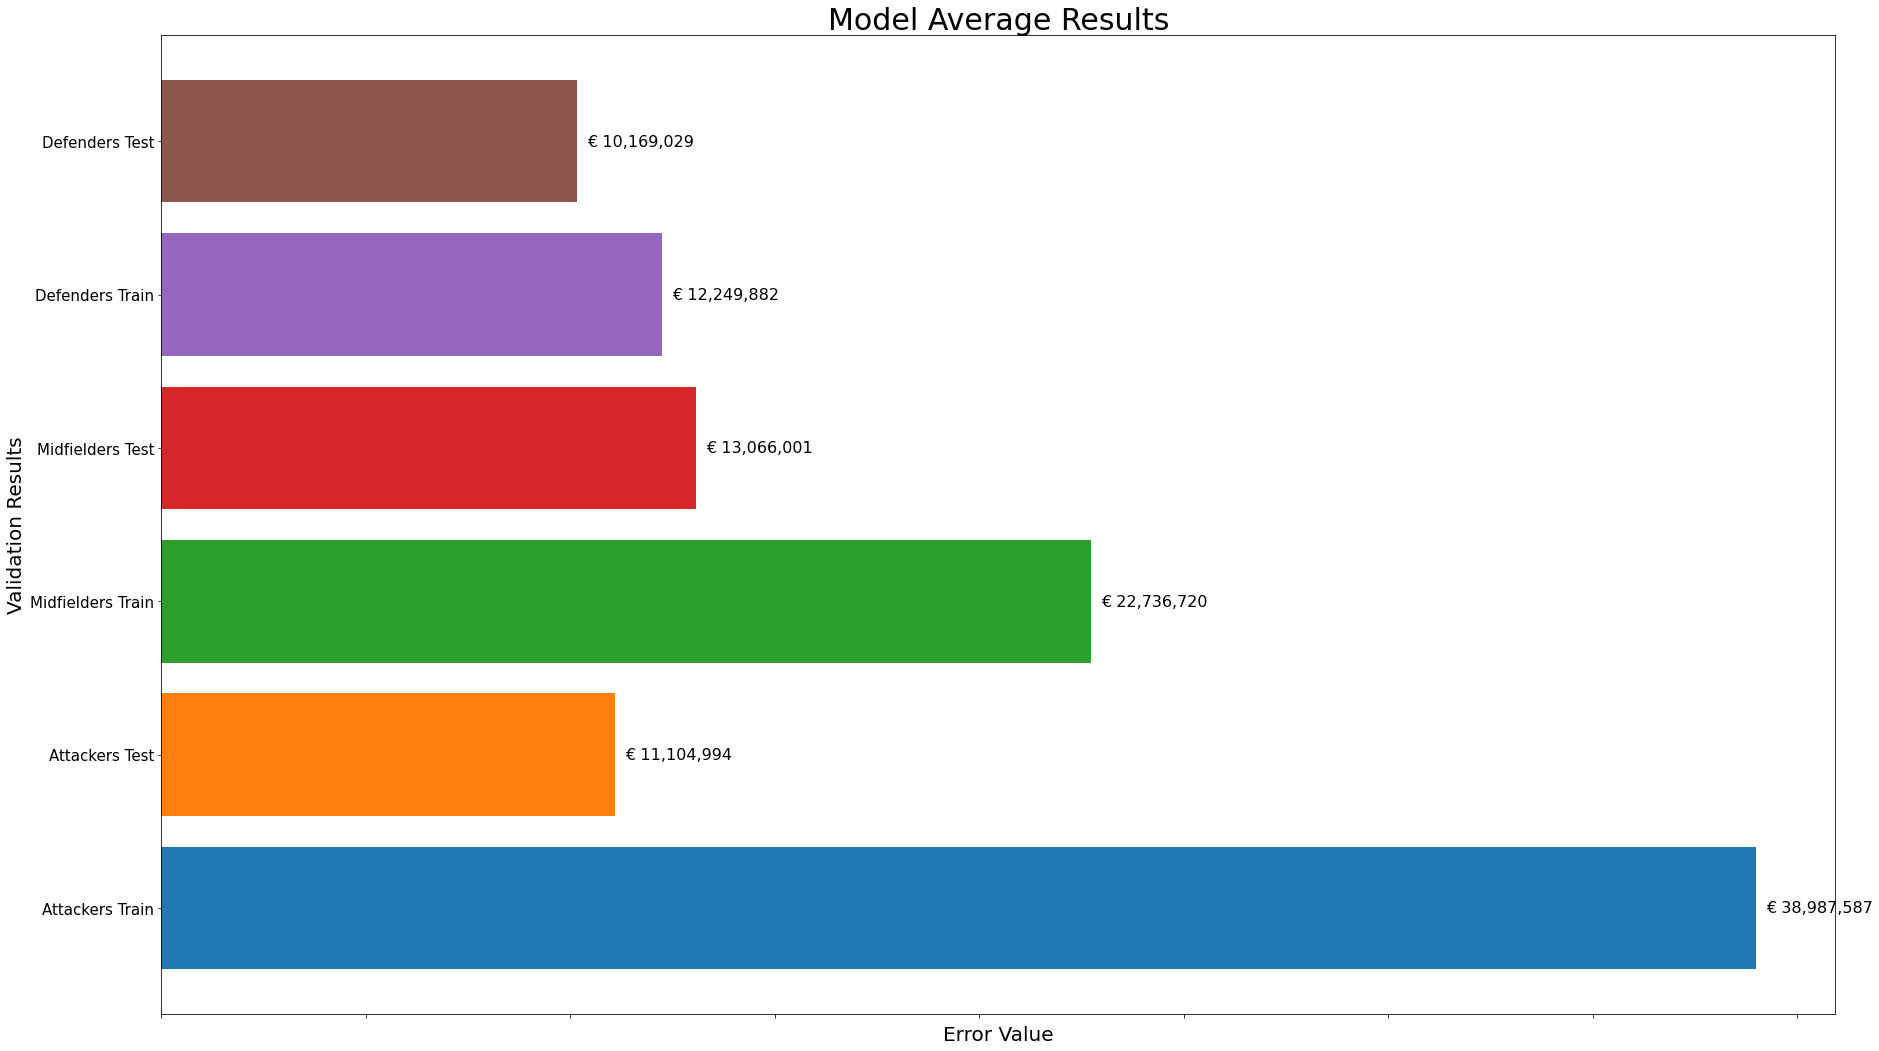

In [362]:
lr_results_gr = model(grouped_position_dict, lr)
make_res_plot(lr_results_gr, grouped_position_dict.keys())

### Linear regression for each positions

C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


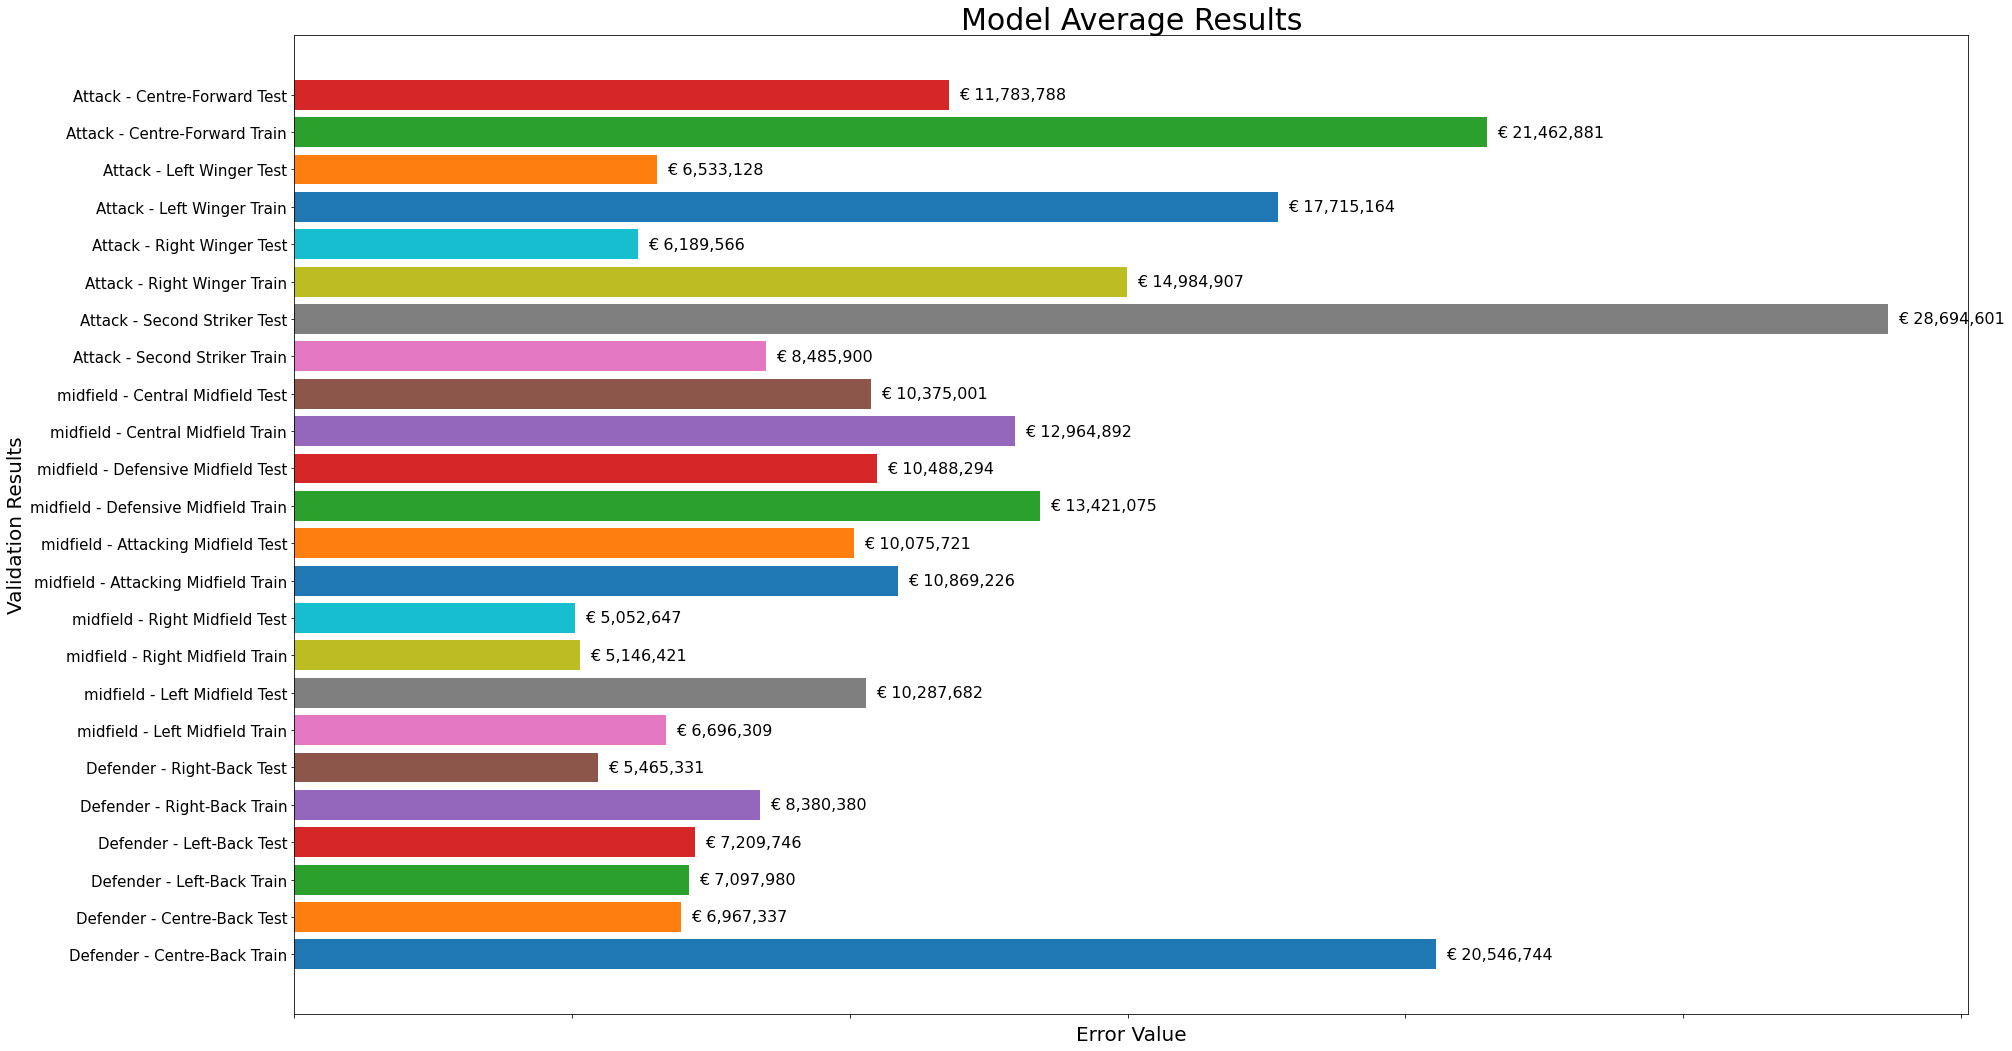

In [359]:
lr_results_each = model(all_position_dict, lr)
make_res_plot(lr_results_each, all_position_dict.keys())

### Linear regression without specified position

C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


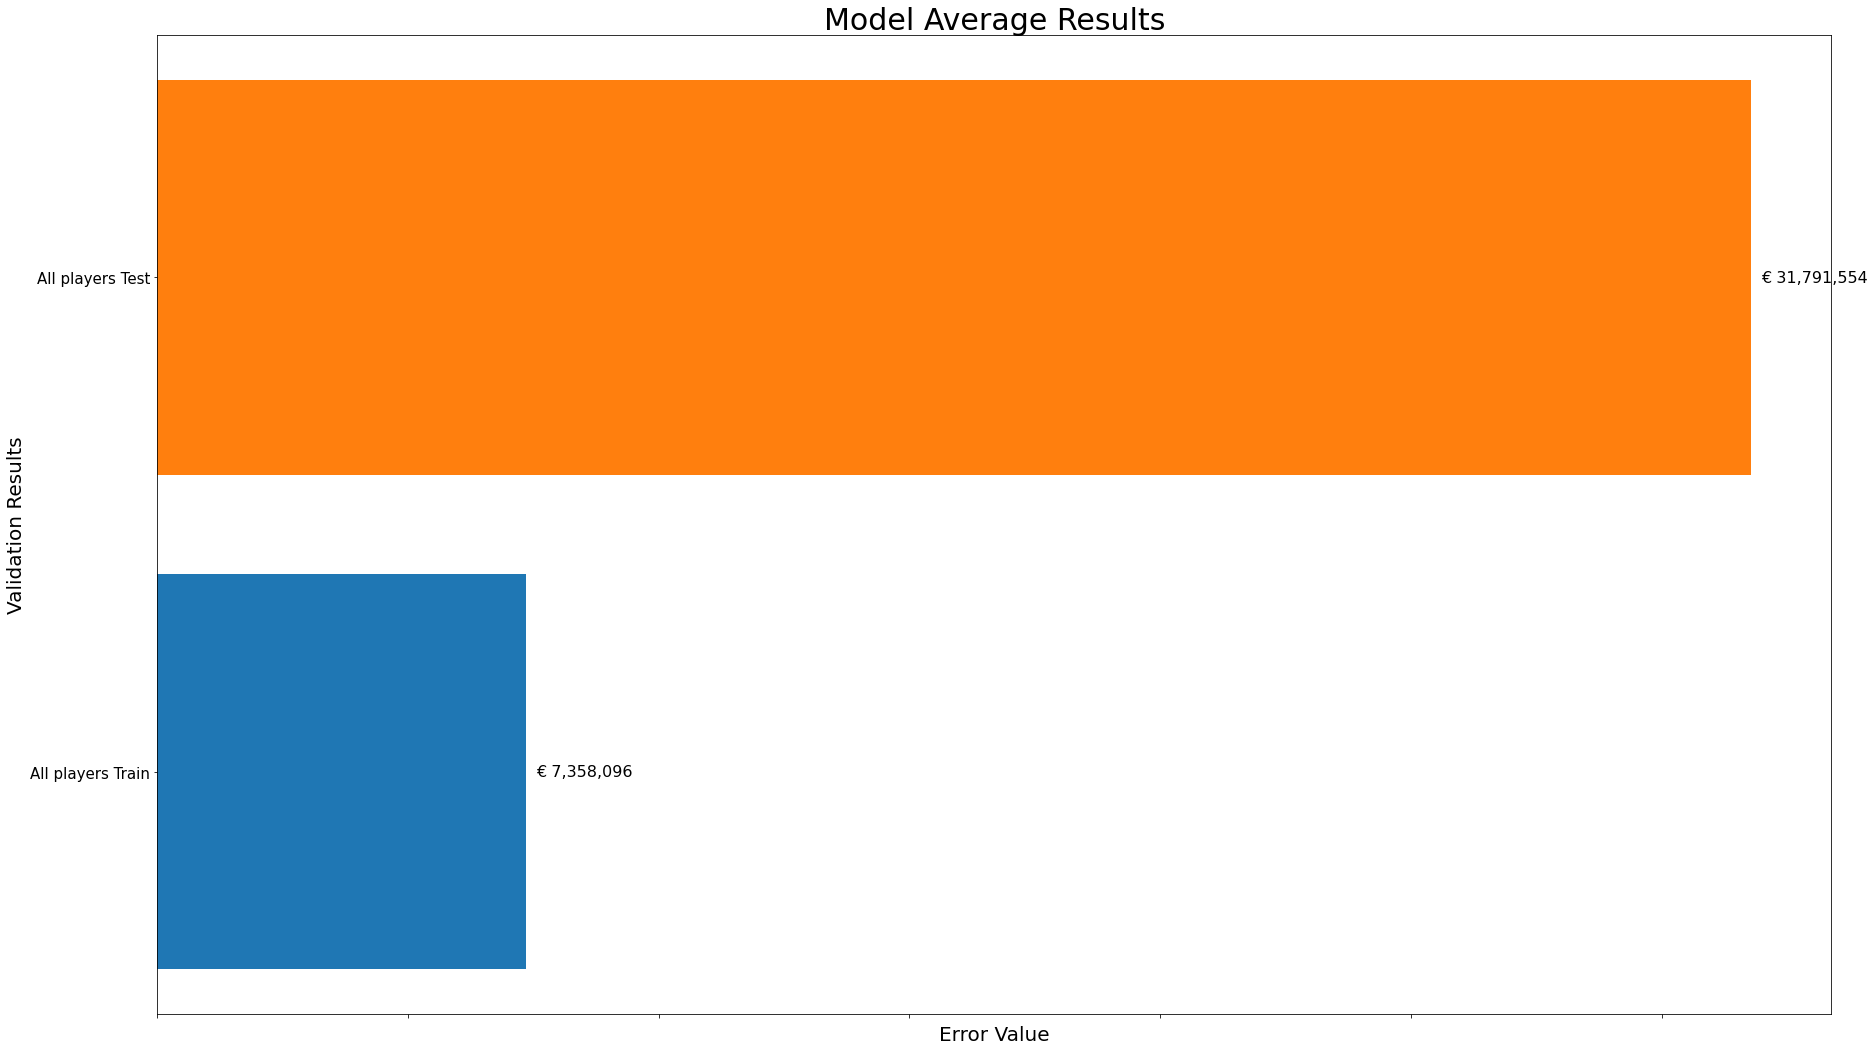

In [361]:
lr_results_np = model(non_grouped_position_dict, lr)
make_res_plot(lr_results_np, non_grouped_position_dict.keys())

## Lasso Regression

In [77]:
la = Lasso()

### Lasso regression for grouped positions

c:\Users\vegas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.180e+16, tolerance: 1.760e+13
  model = cd_fast.enet_coordinate_descent(
c:\Users\vegas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.823e+15, tolerance: 1.150e+13
  model = cd_fast.enet_coordinate_descent(
c:\Users\vegas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

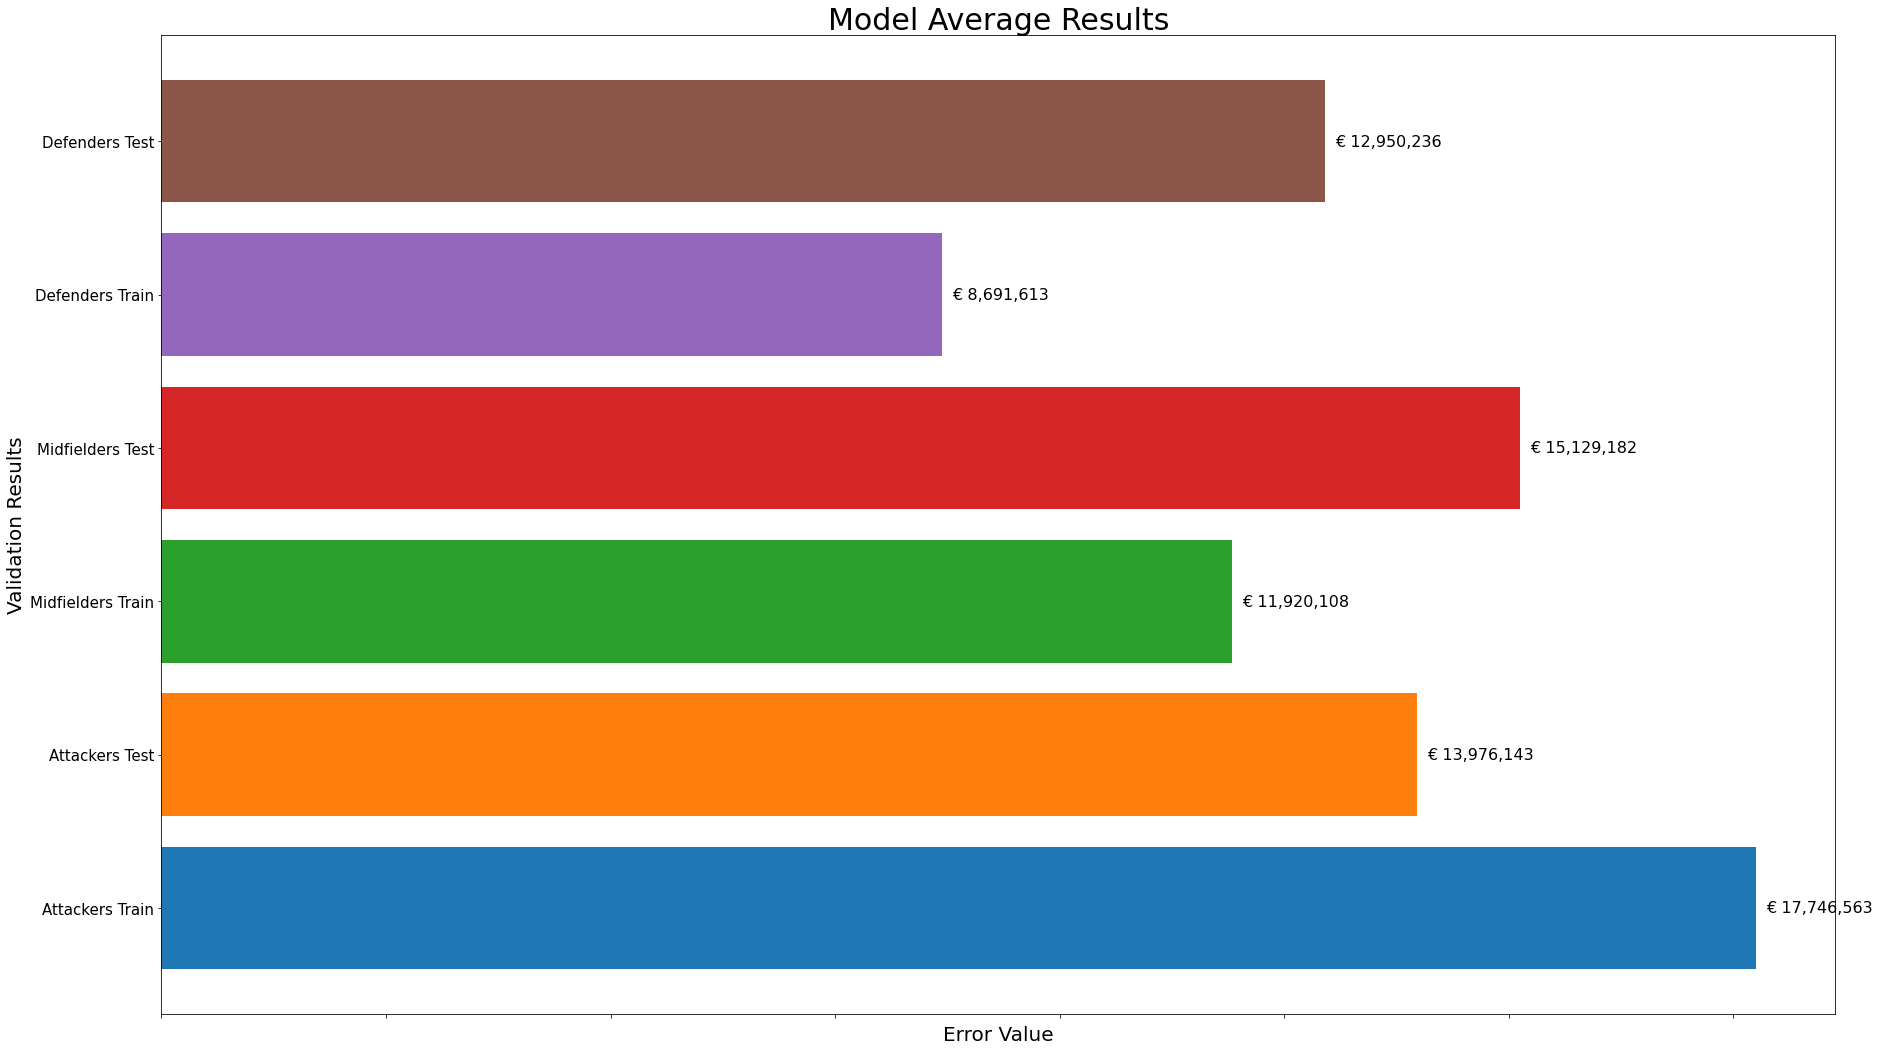

In [365]:
la_results_gr = model(grouped_position_dict, la)
make_res_plot(la_results_gr, grouped_position_dict.keys())

### Lasso regression for each position

c:\Users\vegas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.903e+14, tolerance: 6.101e+12
  model = cd_fast.enet_coordinate_descent(
c:\Users\vegas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.594e+13, tolerance: 4.822e+12
  model = cd_fast.enet_coordinate_descent(
c:\Users\vegas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

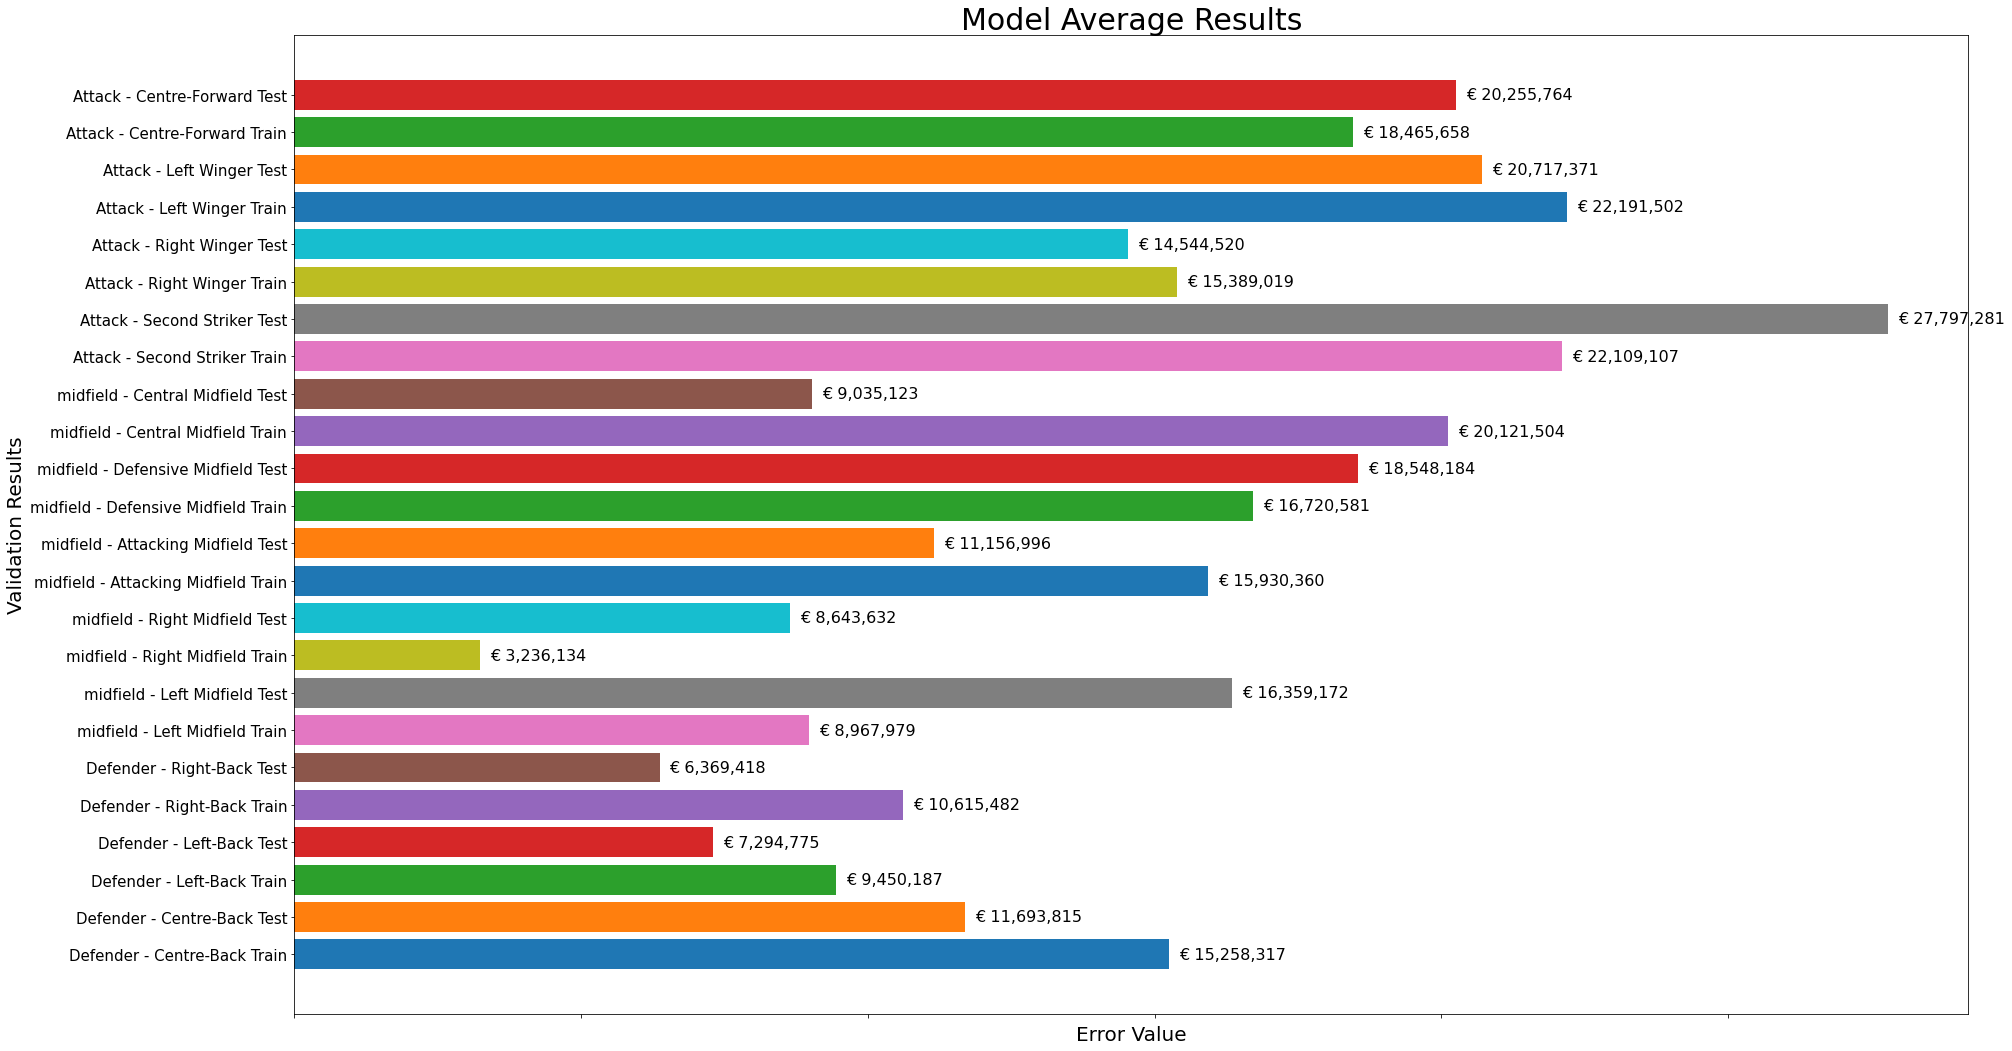

In [372]:
la_results_each = model(all_position_dict, la)
make_res_plot(la_results_each, all_position_dict.keys())

### Lasso regression without specified position

c:\Users\vegas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.033e+16, tolerance: 4.595e+13
  model = cd_fast.enet_coordinate_descent(
c:\Users\vegas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.932e+16, tolerance: 3.699e+13
  model = cd_fast.enet_coordinate_descent(
c:\Users\vegas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

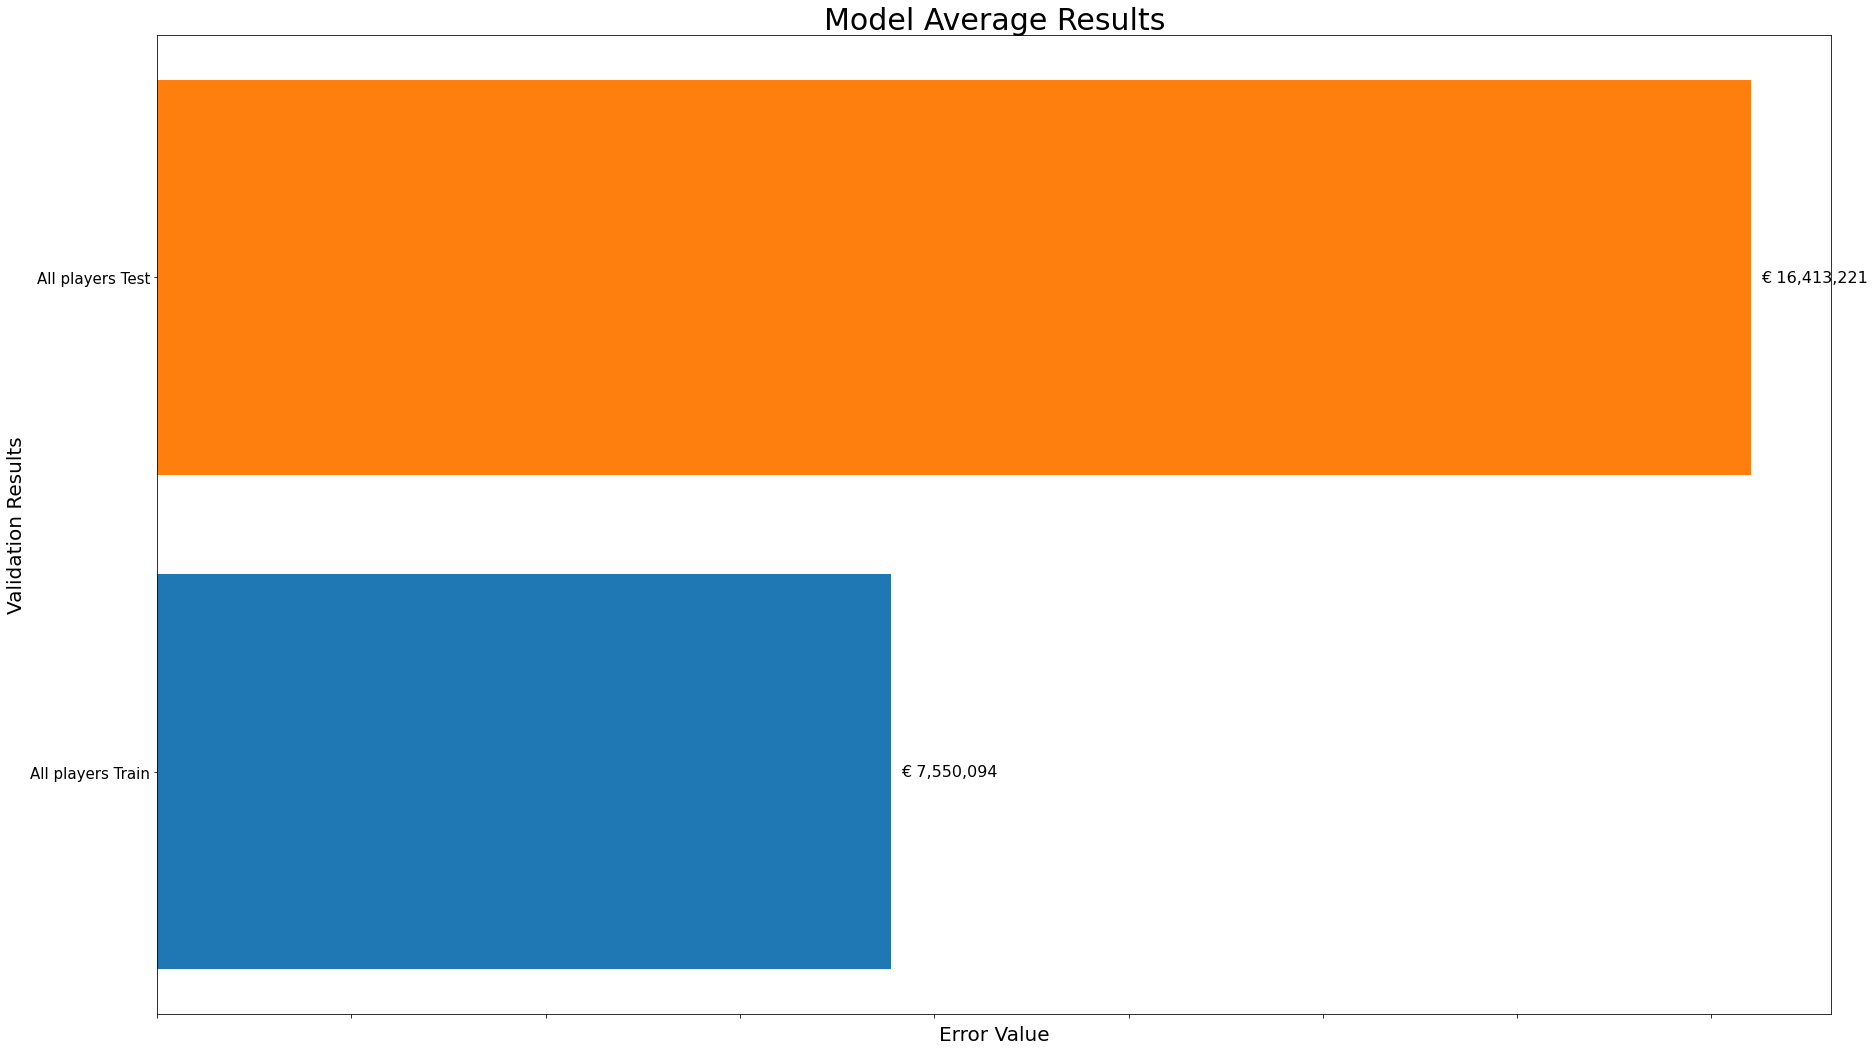

In [374]:
la_results_np = model(non_grouped_position_dict, la)
make_res_plot(la_results_np, non_grouped_position_dict.keys())

## Ridge Regression

In [82]:
rid = Ridge()

### Ridge regression for grouped positions

C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


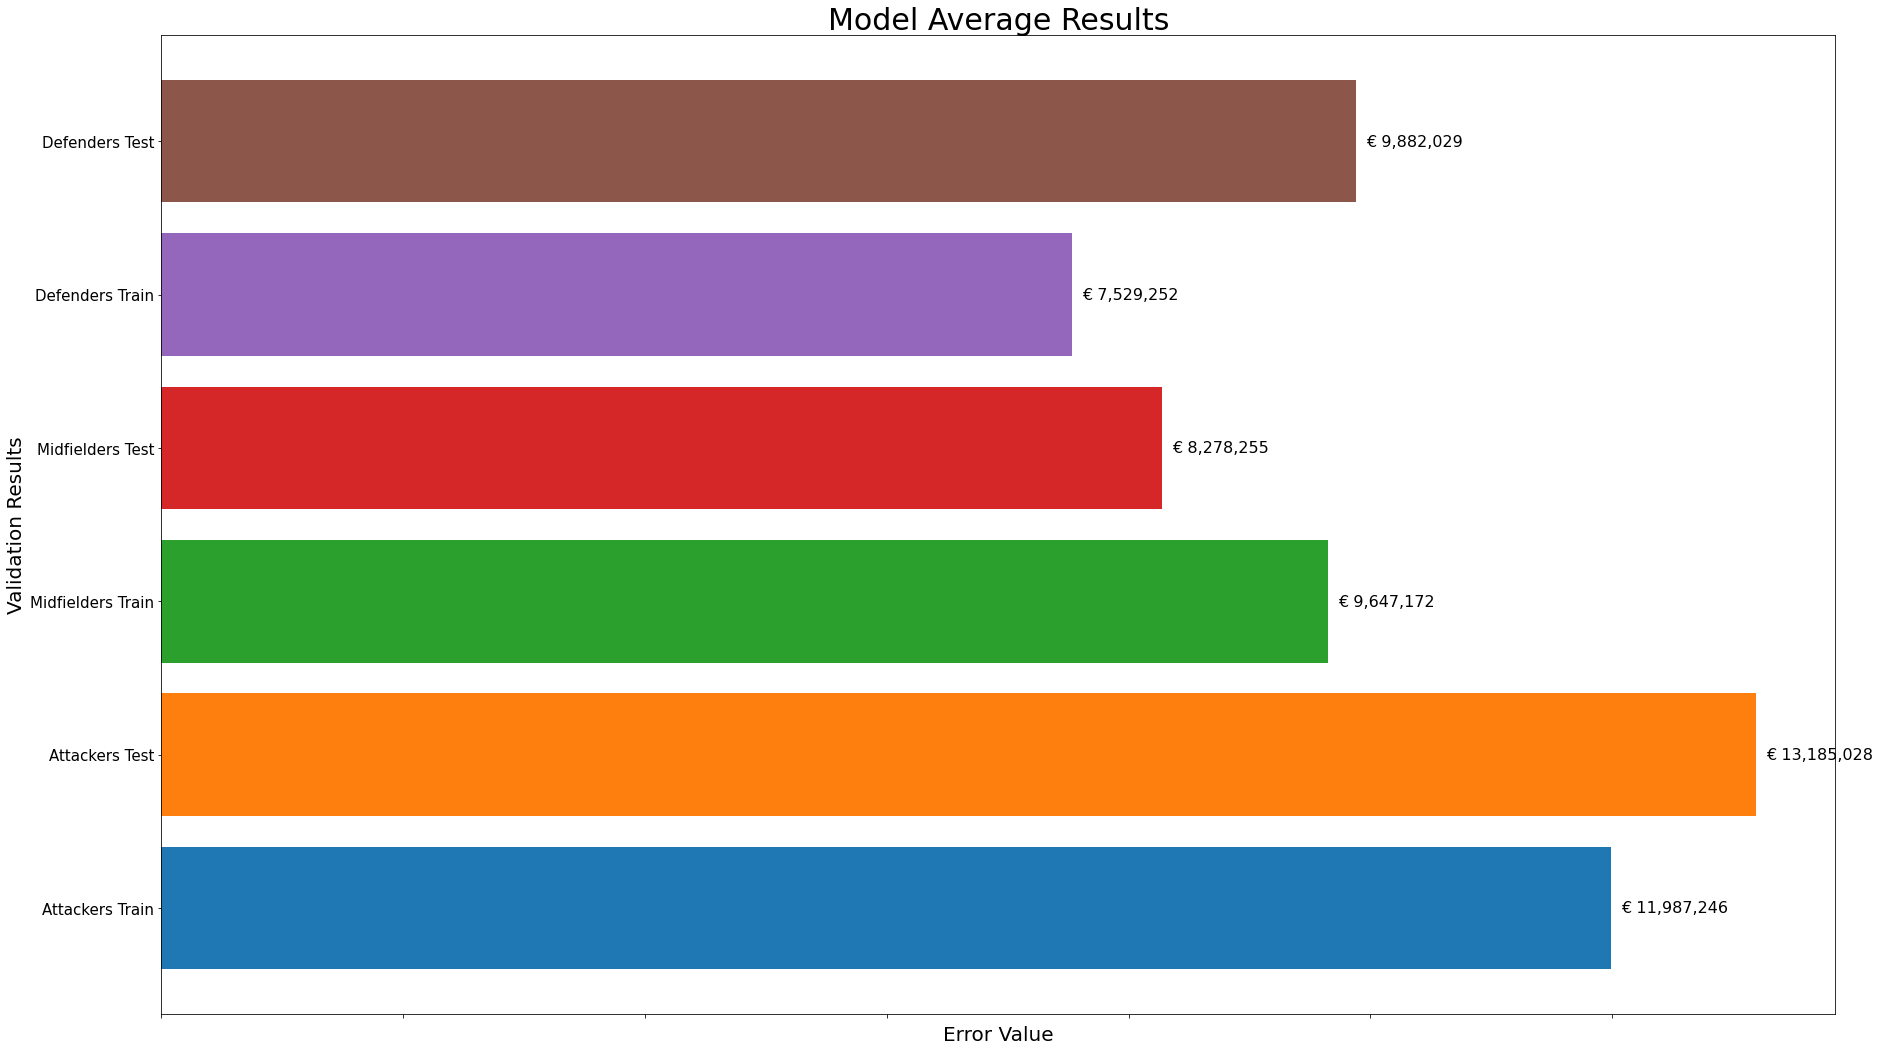

In [375]:
rid_results_gr = model(grouped_position_dict, rid)
make_res_plot(rid_results_gr, grouped_position_dict.keys())

### Ridge regression for each position

C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


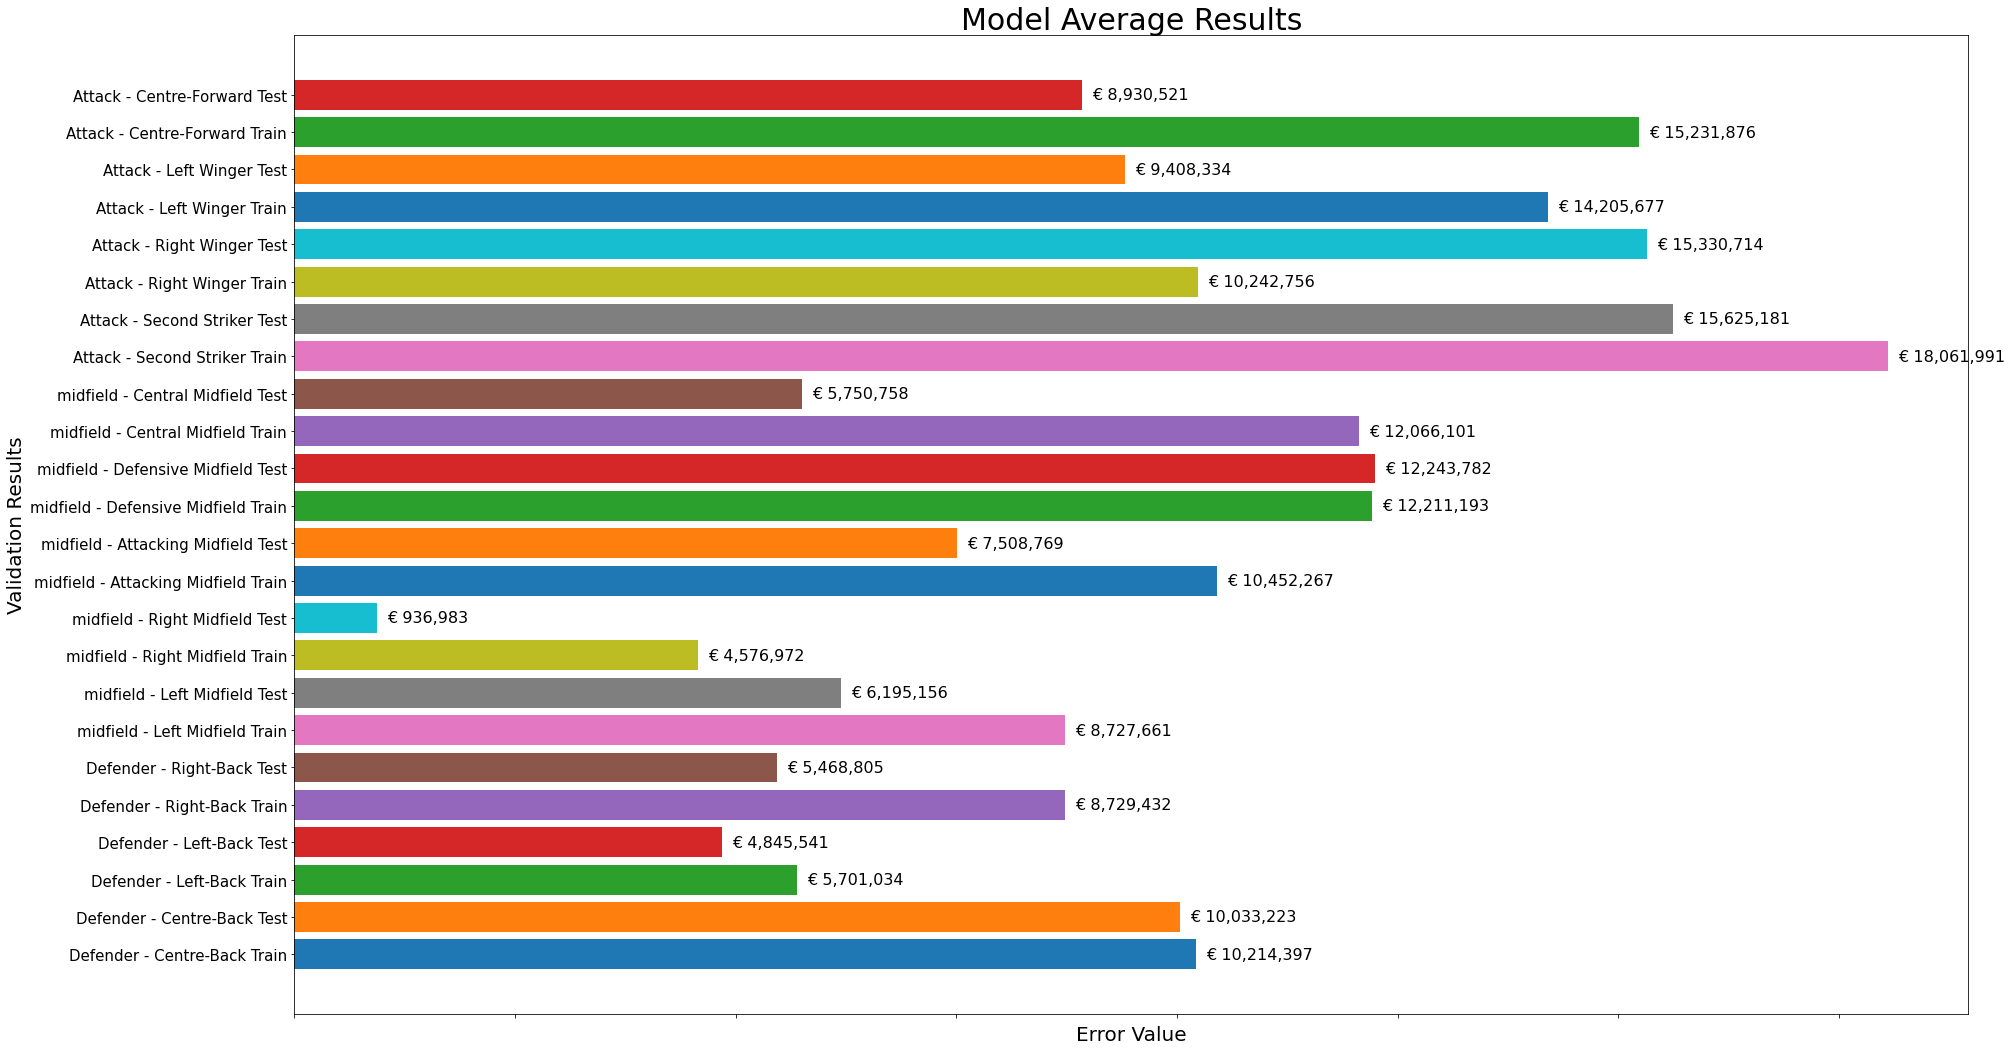

In [376]:
rid_results_each = model(all_position_dict, rid)
make_res_plot(rid_results_each, all_position_dict.keys())

### Ridge regression without specified position

C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


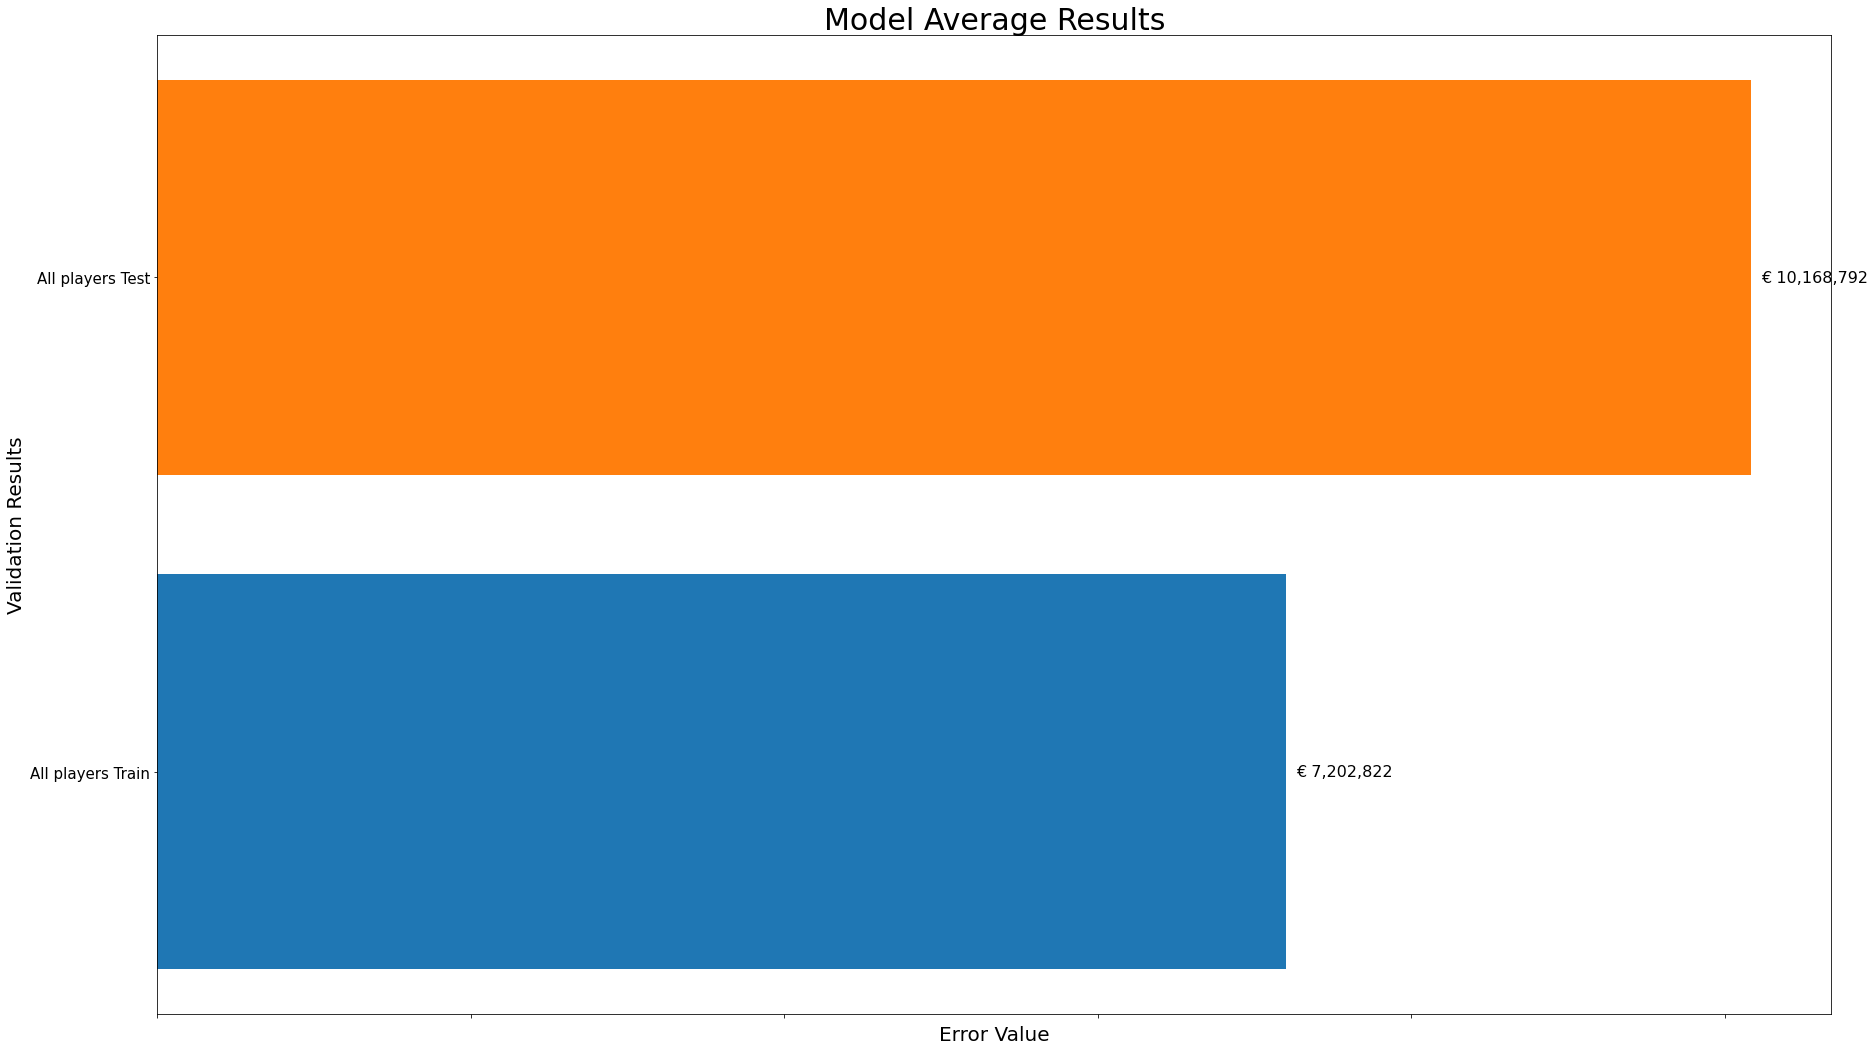

In [378]:
rid_results_np = model(non_grouped_position_dict, rid)
make_res_plot(rid_results_np, non_grouped_position_dict.keys())

## AdaBoost

In [363]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor()

### AdaBoost for grouped positions

C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


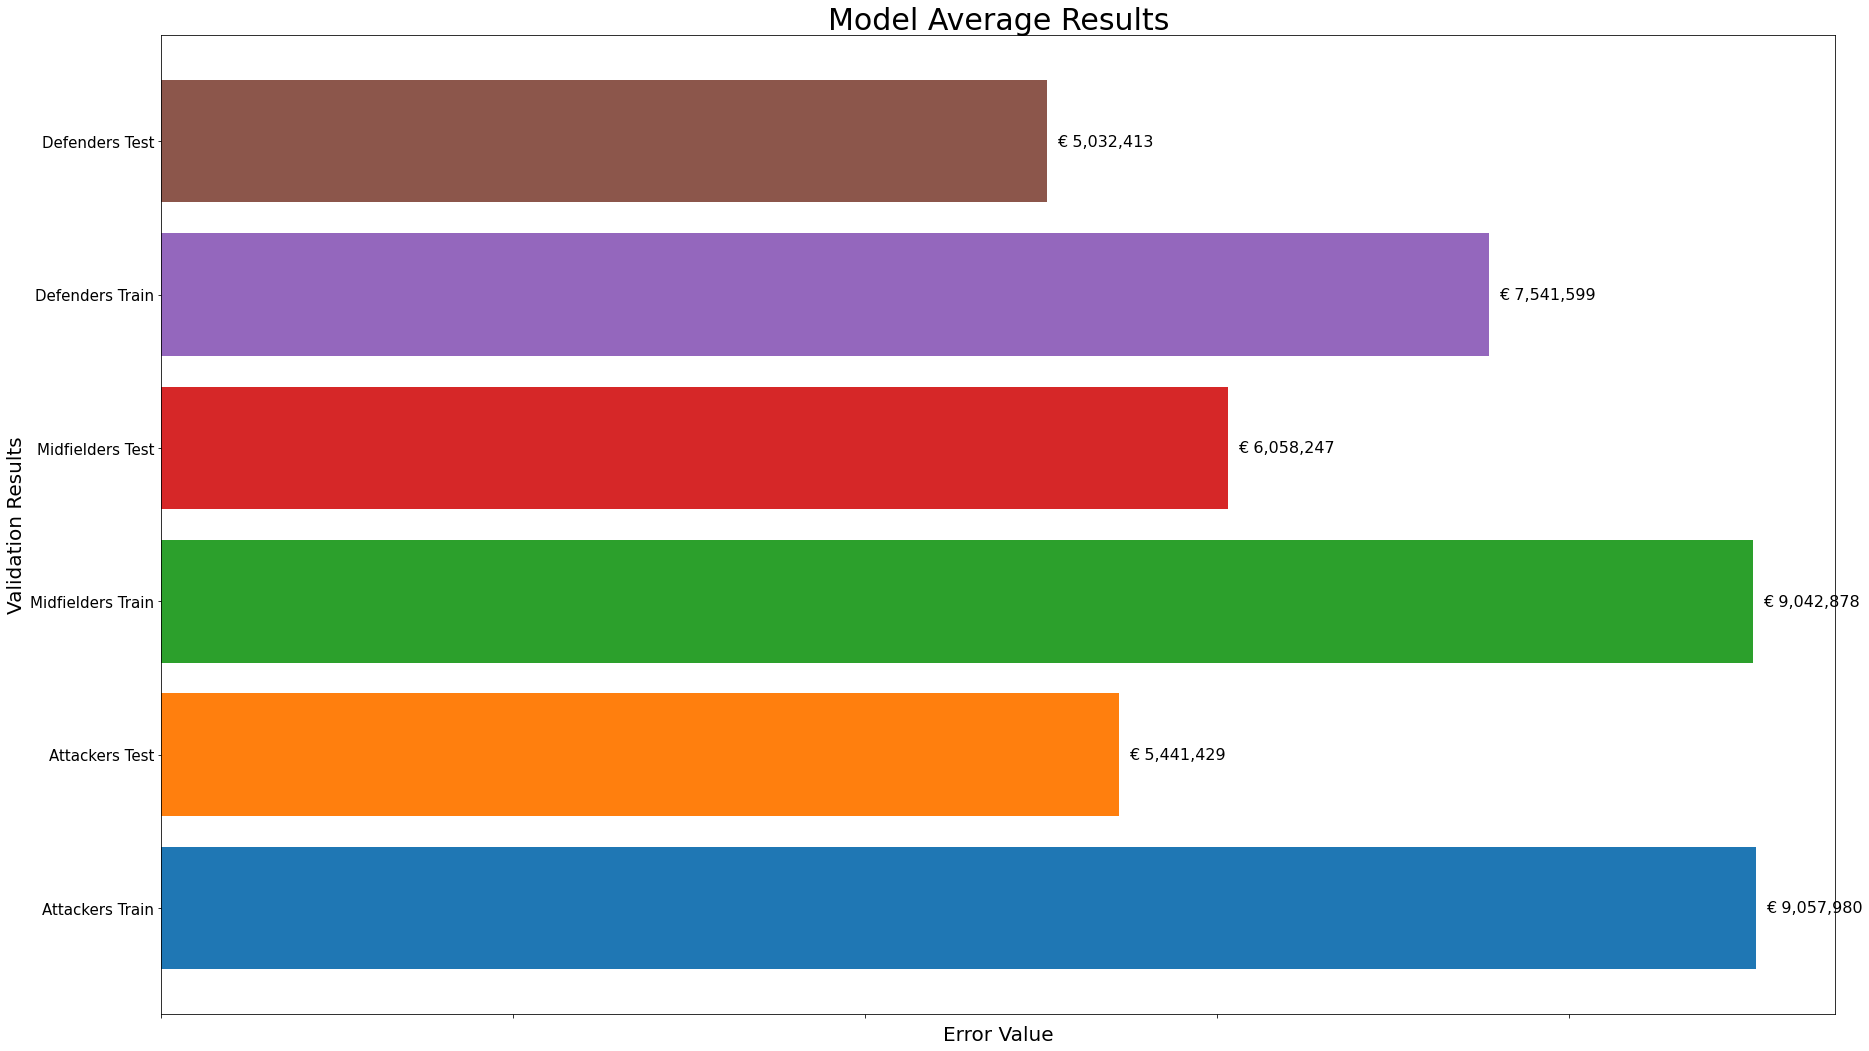

In [379]:
ada_results_gr = model(grouped_position_dict, ada)
make_res_plot(ada_results_gr, grouped_position_dict.keys())

### AdaBoost for each position

C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


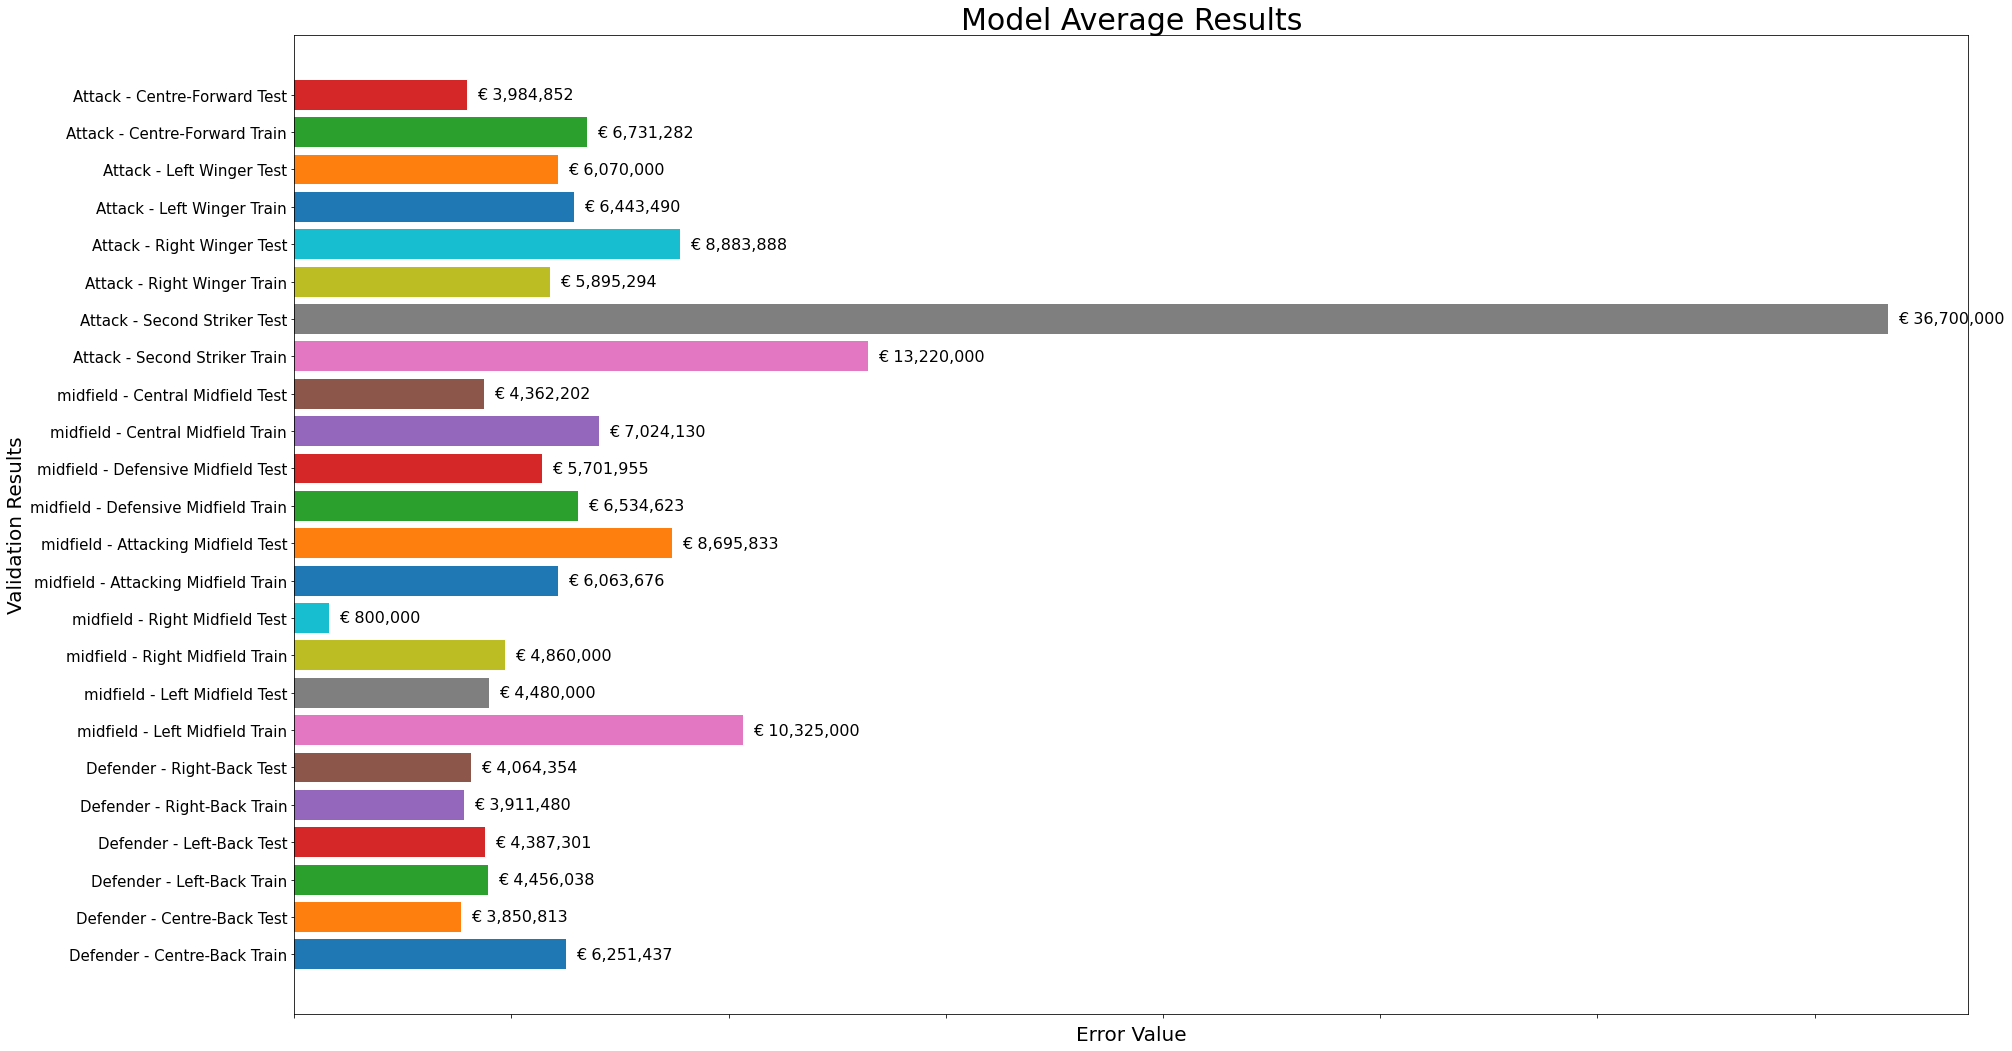

In [380]:
ada_results_each = model(all_position_dict, ada)
make_res_plot(ada_results_each, all_position_dict.keys())

### AdaBoost without specified position

C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


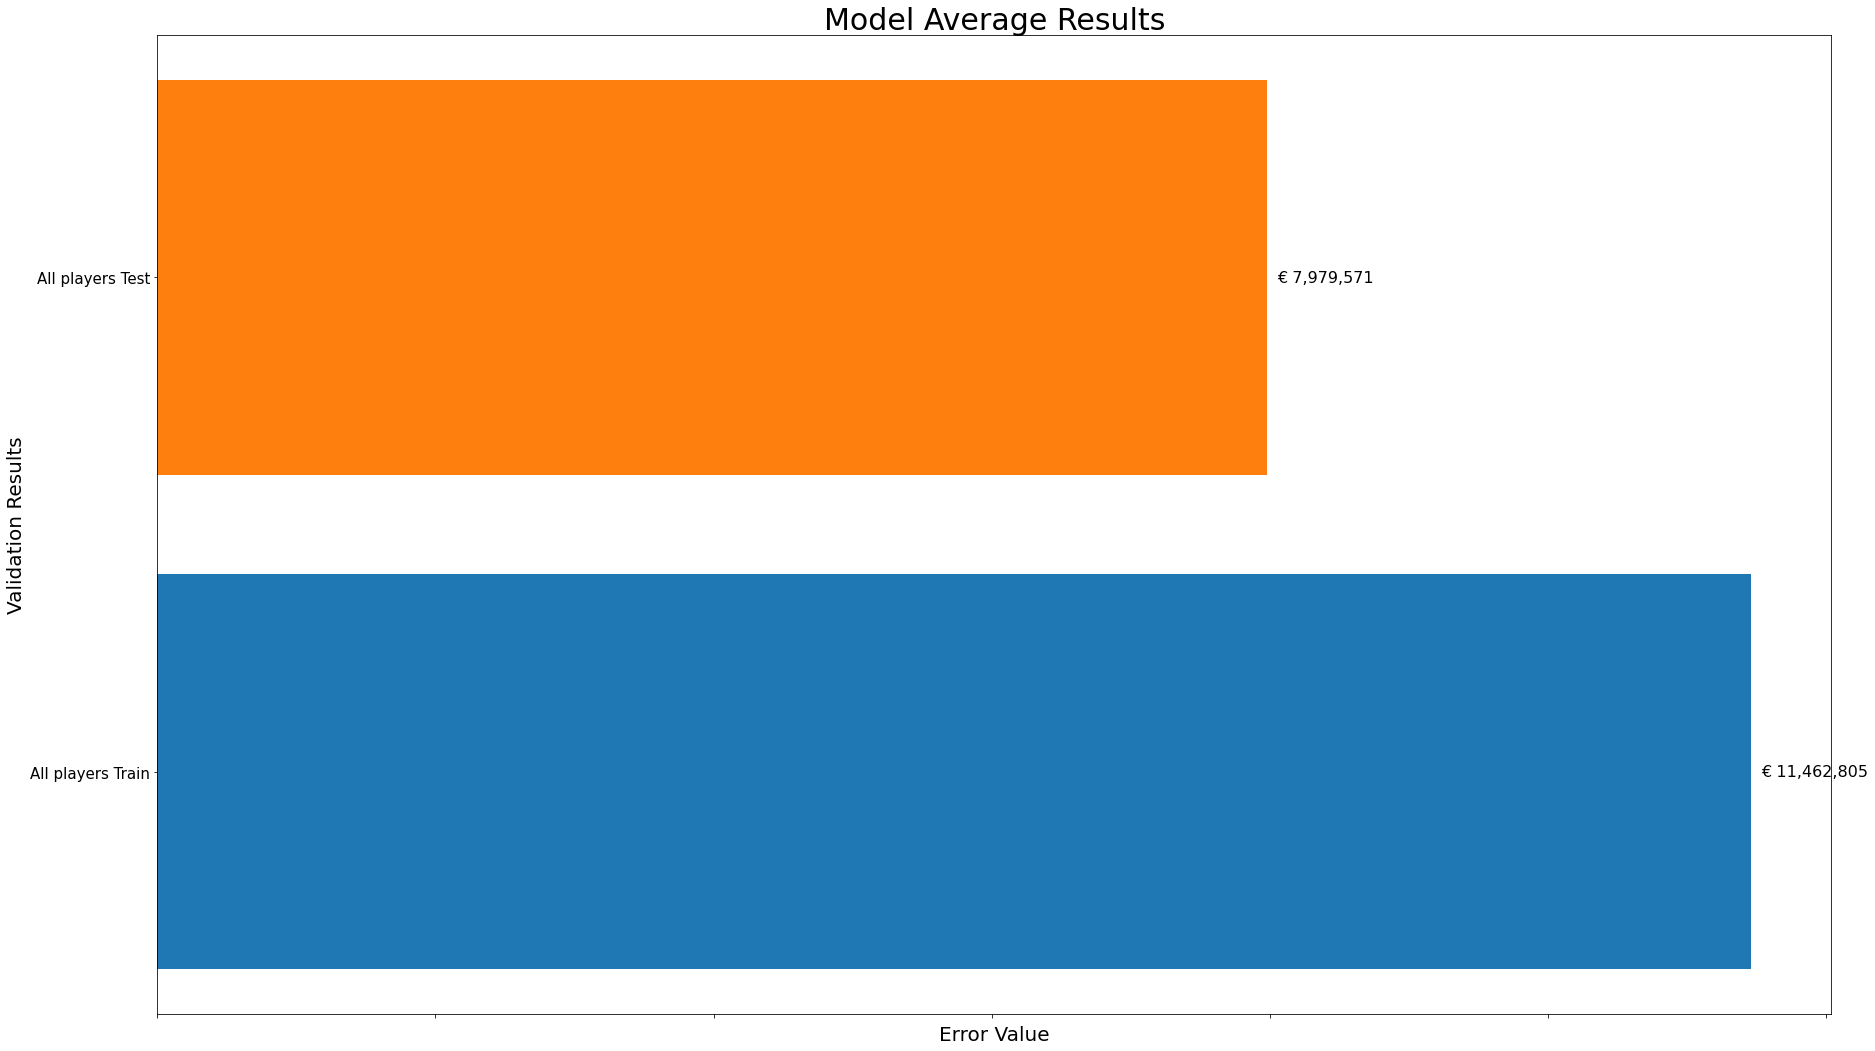

In [381]:
ada_results_np = model(non_grouped_position_dict, ada)
make_res_plot(ada_results_np, non_grouped_position_dict.keys())

## GradientBoost

In [382]:
from sklearn.ensemble import GradientBoostingRegressor


gbt = GradientBoostingRegressor()

### GradientBoost for grouped positions

C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


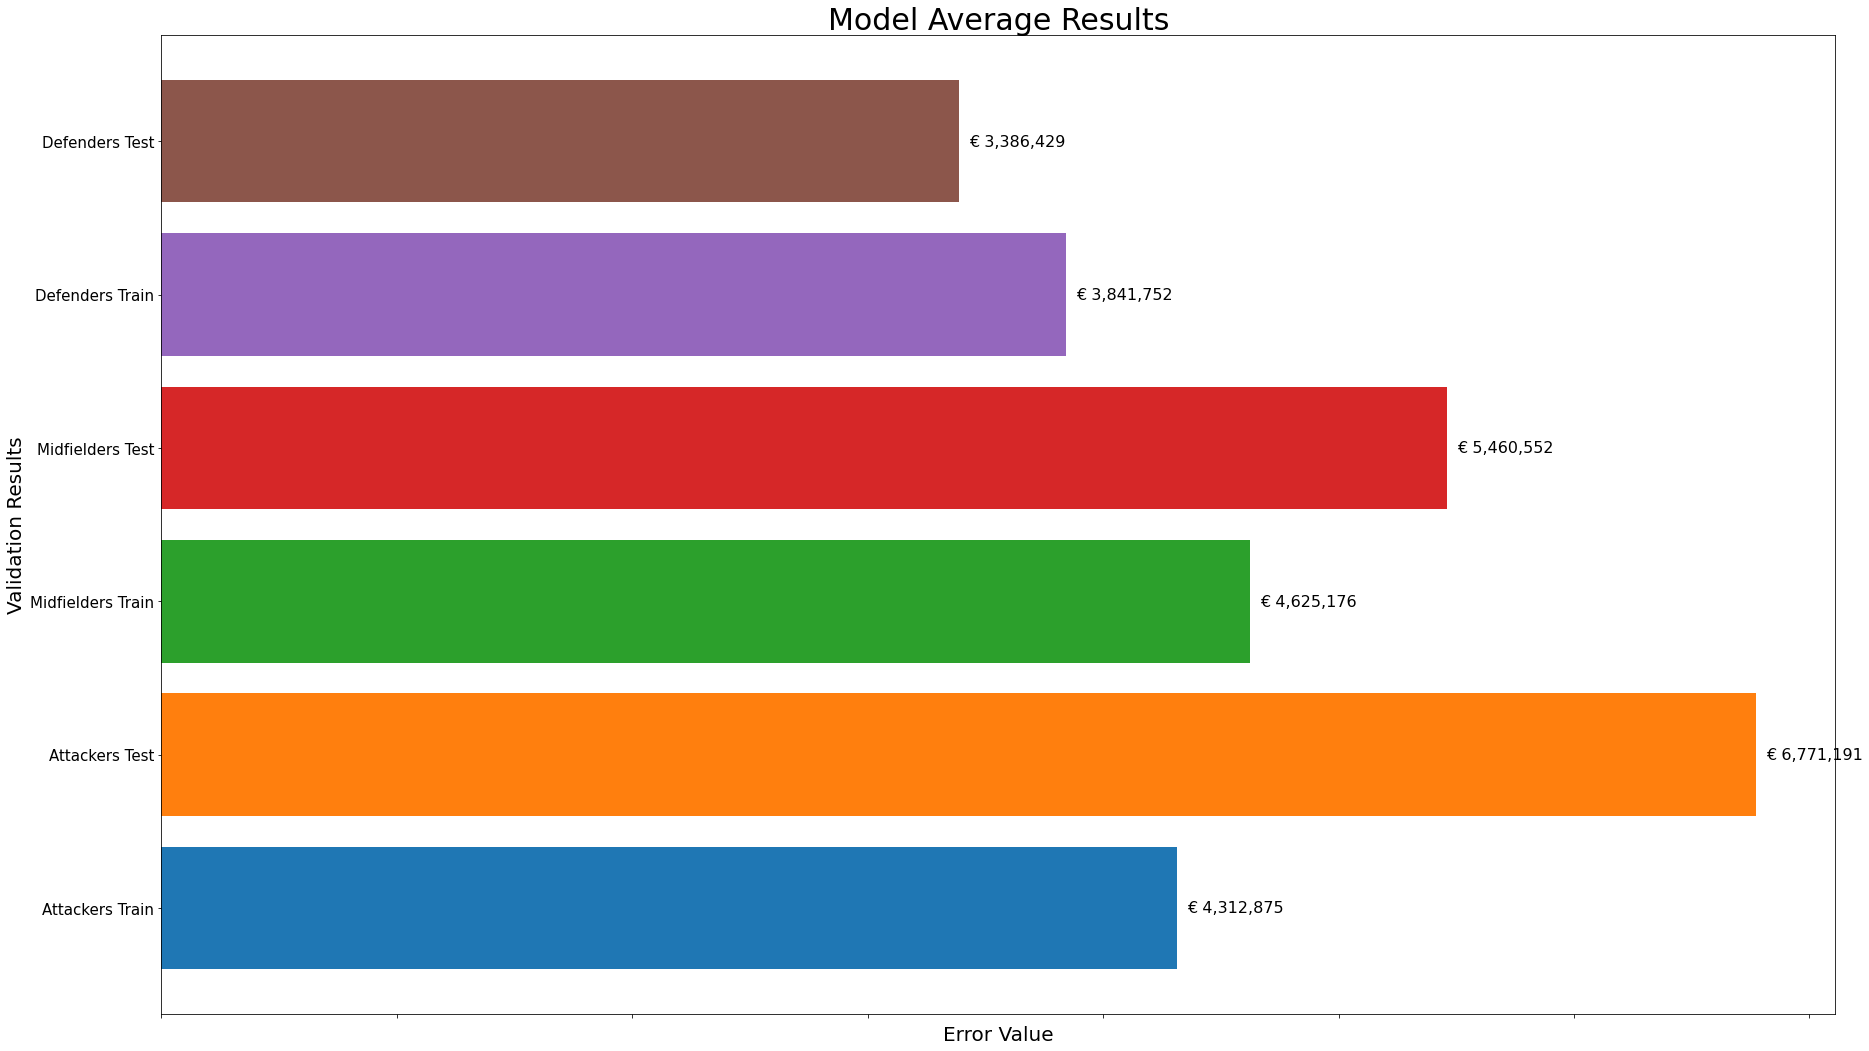

In [383]:
gbt_results_gr = model(grouped_position_dict, gbt)
make_res_plot(gbt_results_gr, grouped_position_dict.keys())

### GradientBoost for each position

C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


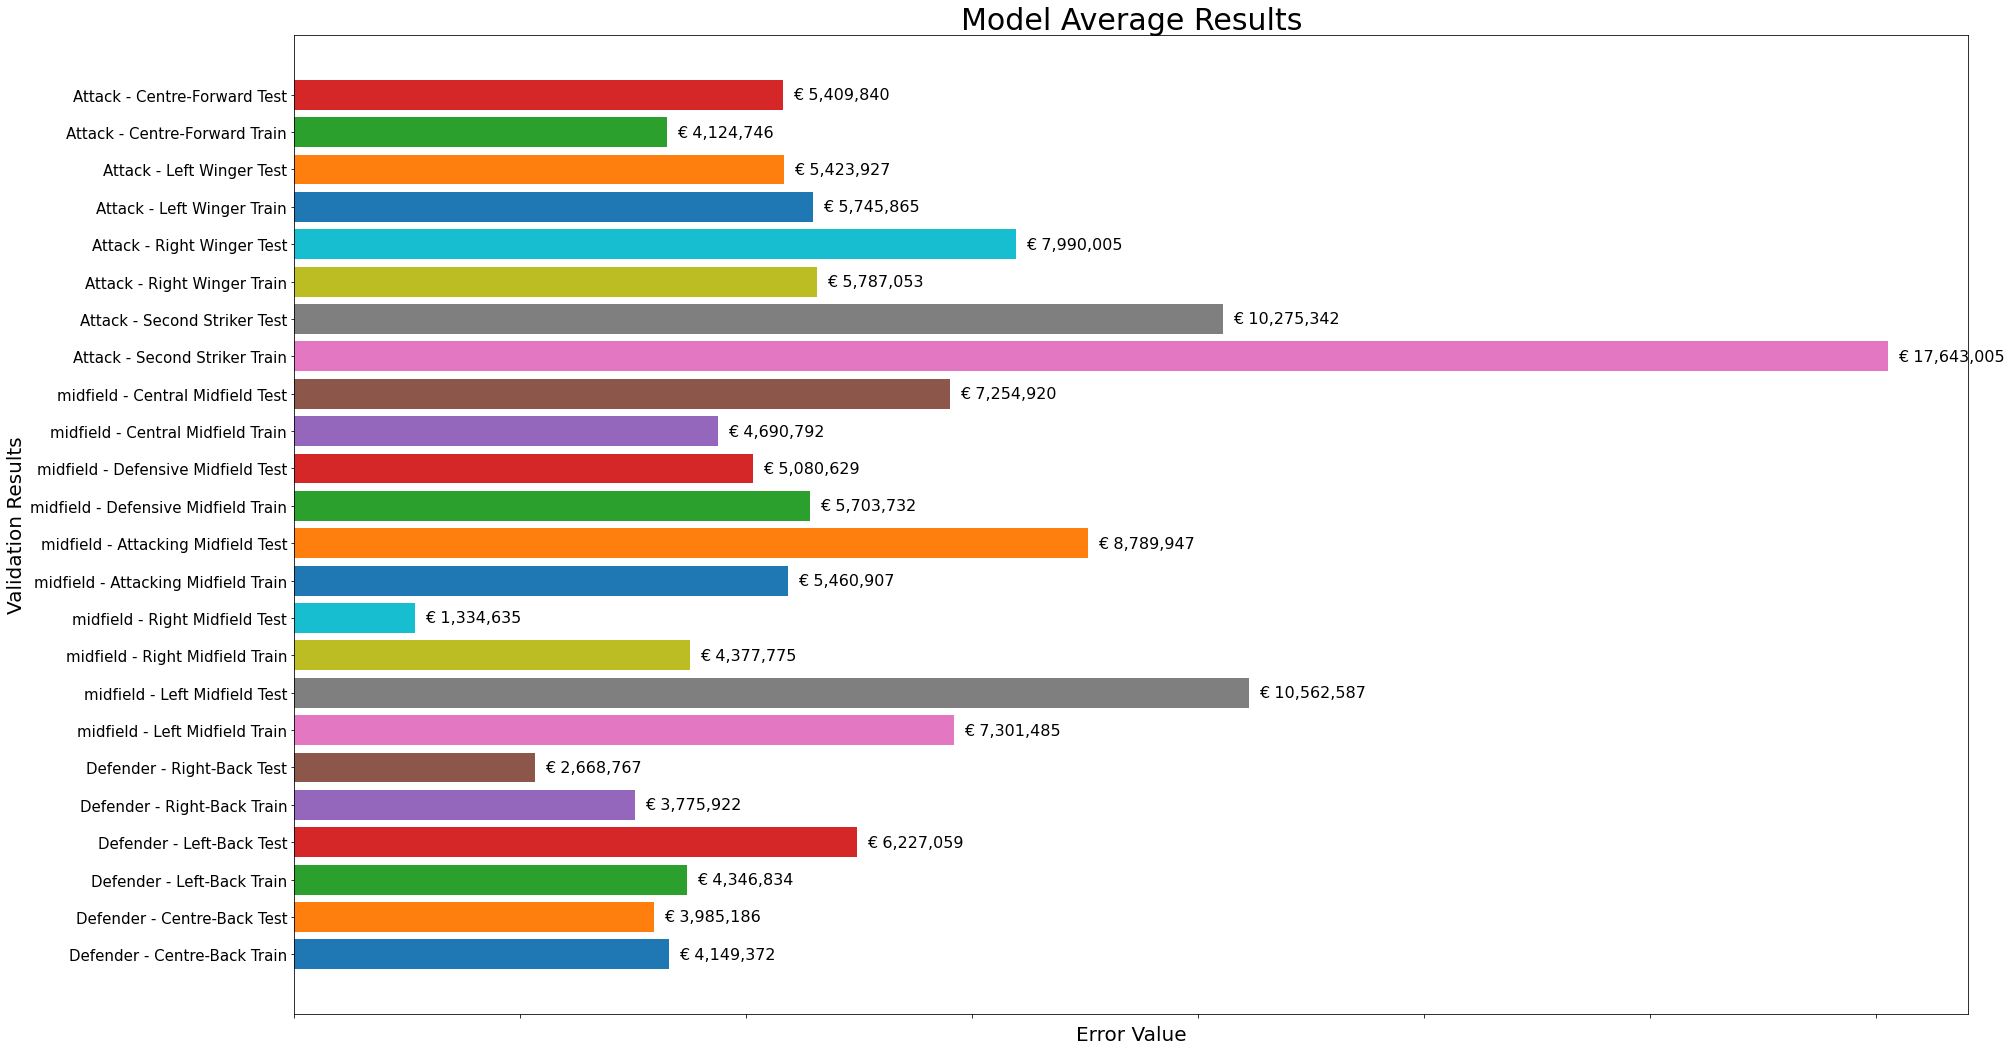

In [384]:
gbt_results_each = model(all_position_dict, gbt)
make_res_plot(gbt_results_each, all_position_dict.keys())

### GradientBoost without specified position

C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


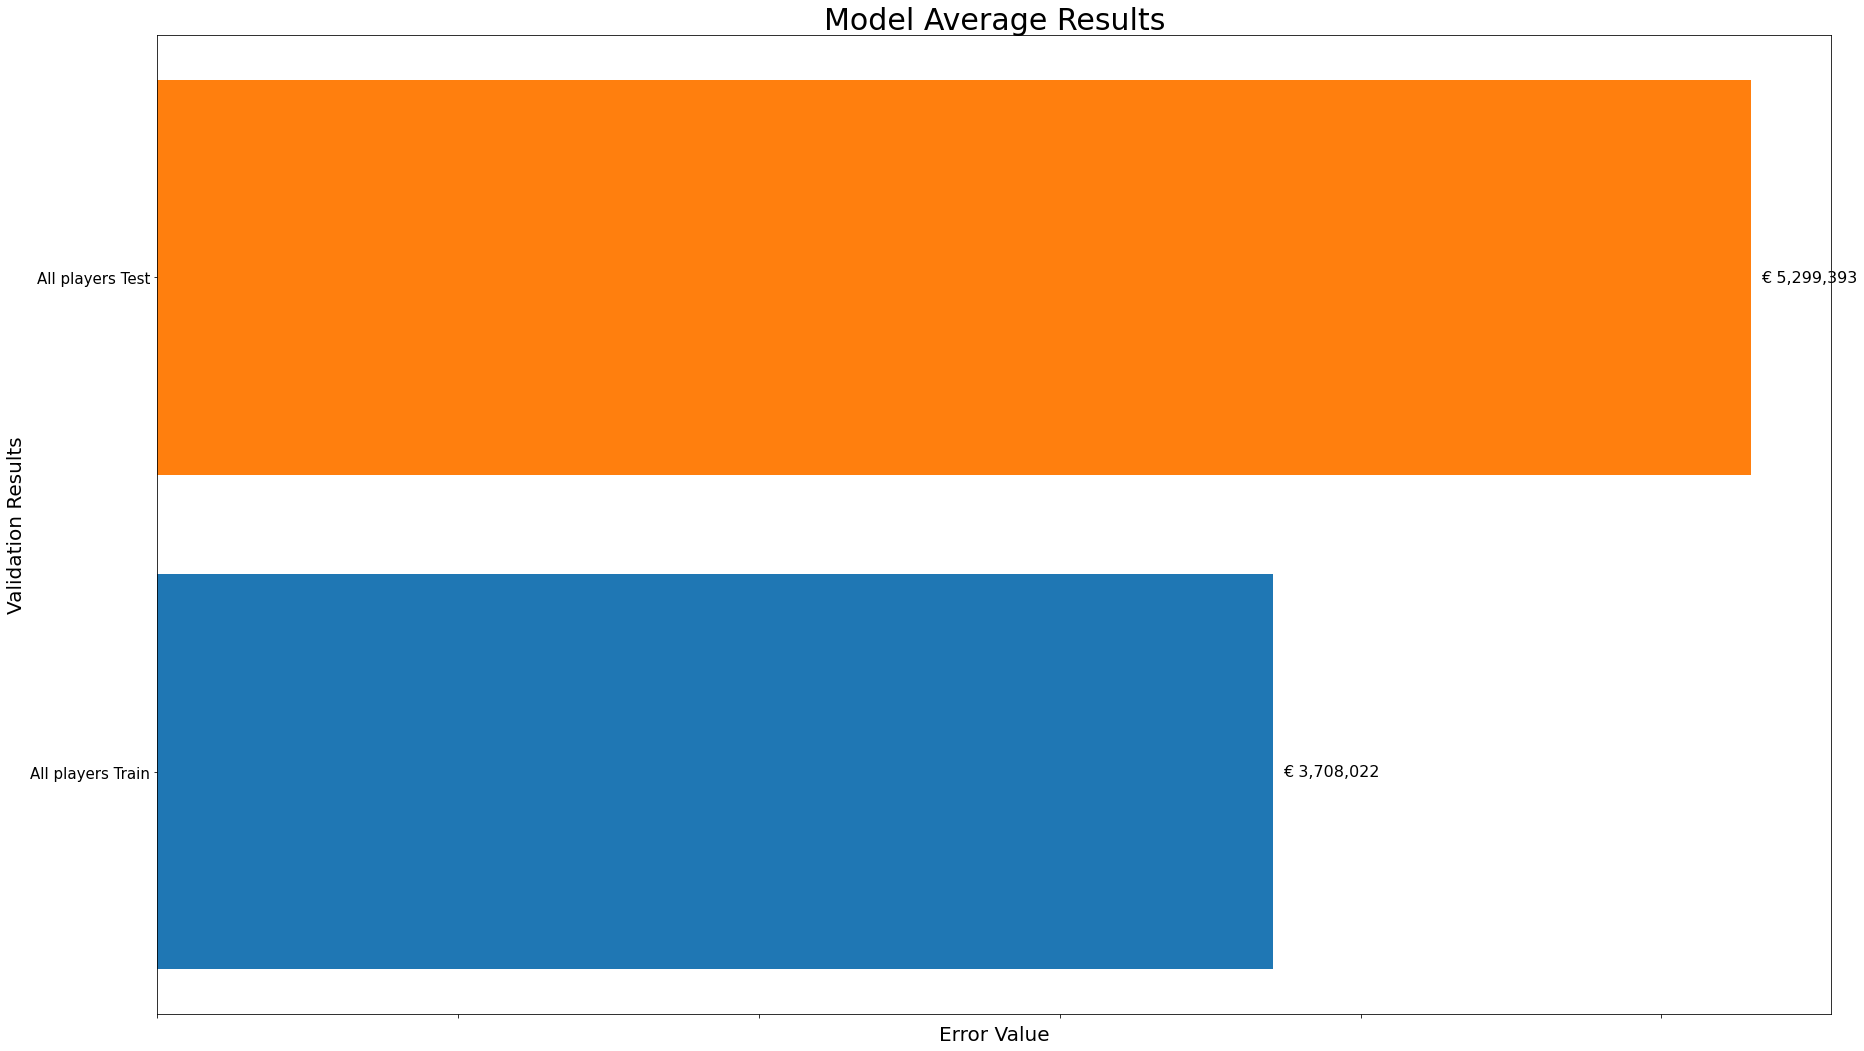

In [385]:
gbt_results_np = model(non_grouped_position_dict, gbt)
make_res_plot(gbt_results_np, non_grouped_position_dict.keys())

## RandomForest

In [222]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor()

### RandomForest for grouped positions


C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


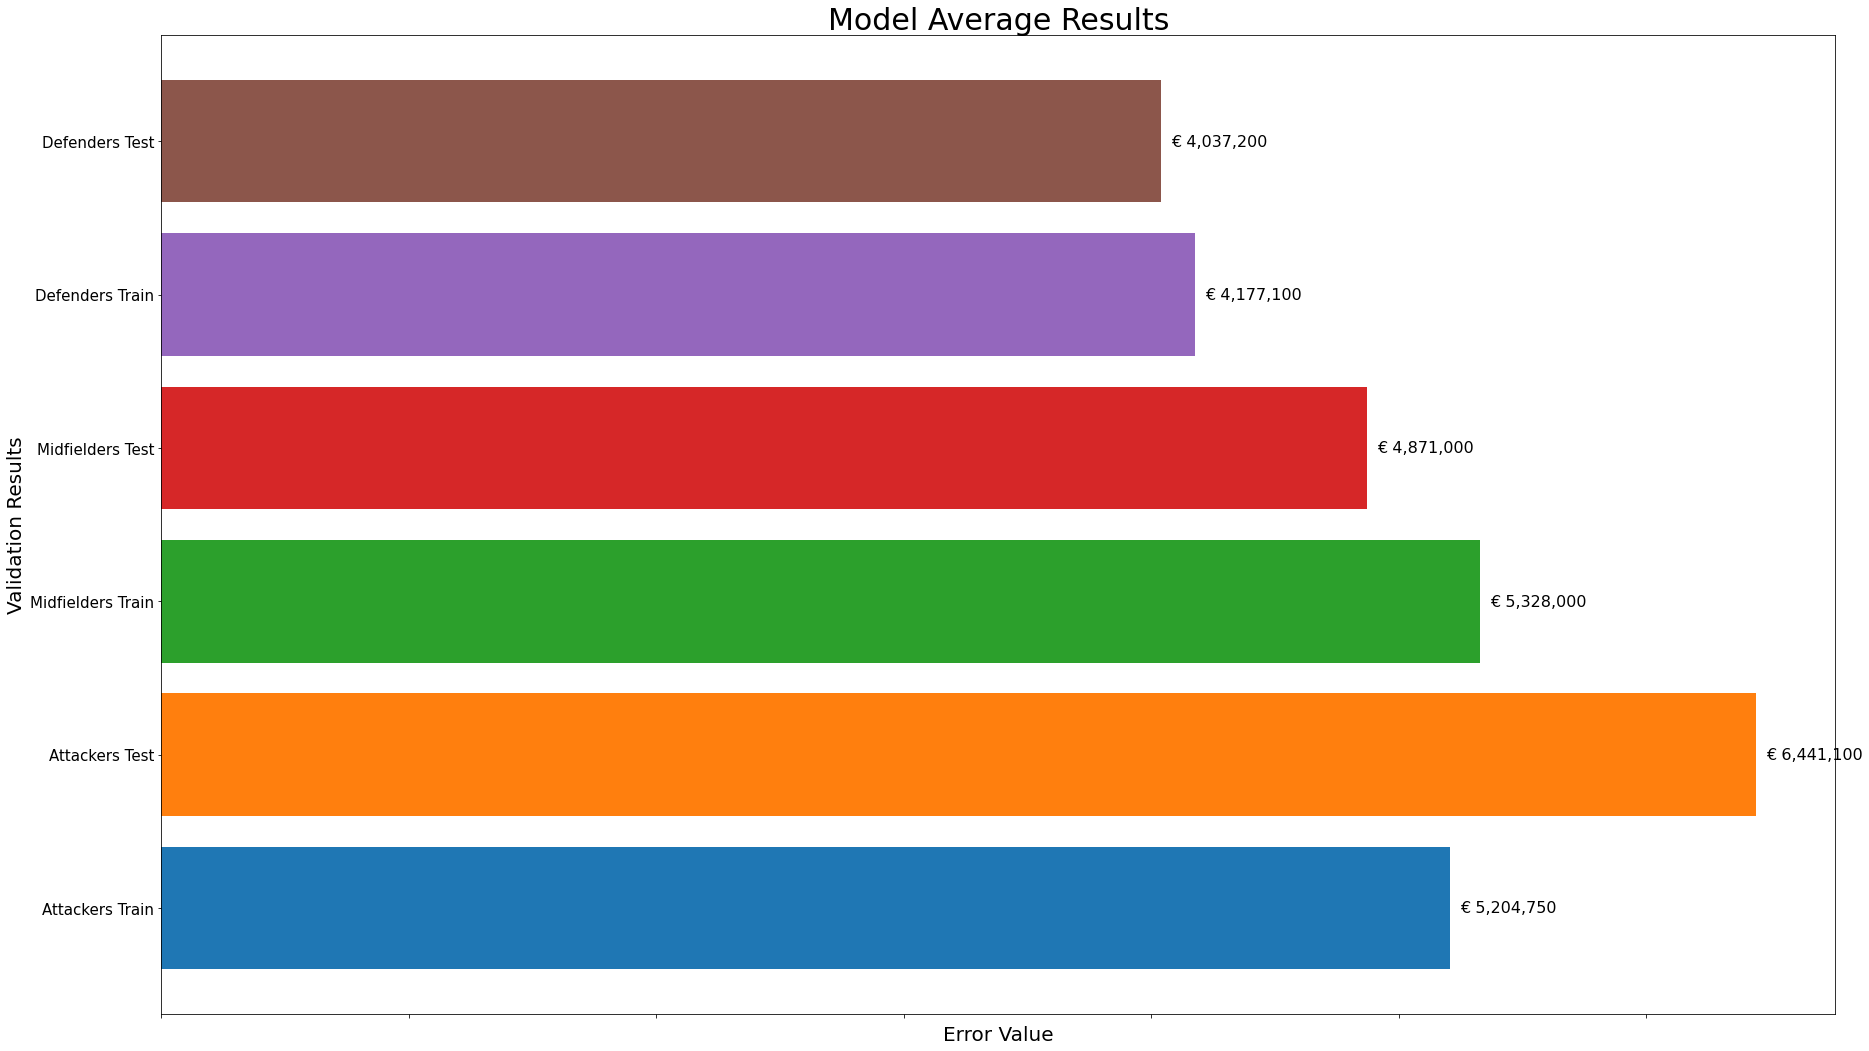

In [386]:
rf_results_gr = model(grouped_position_dict, rf)
make_res_plot(rf_results_gr, grouped_position_dict.keys())

### RandomForest for each position

C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


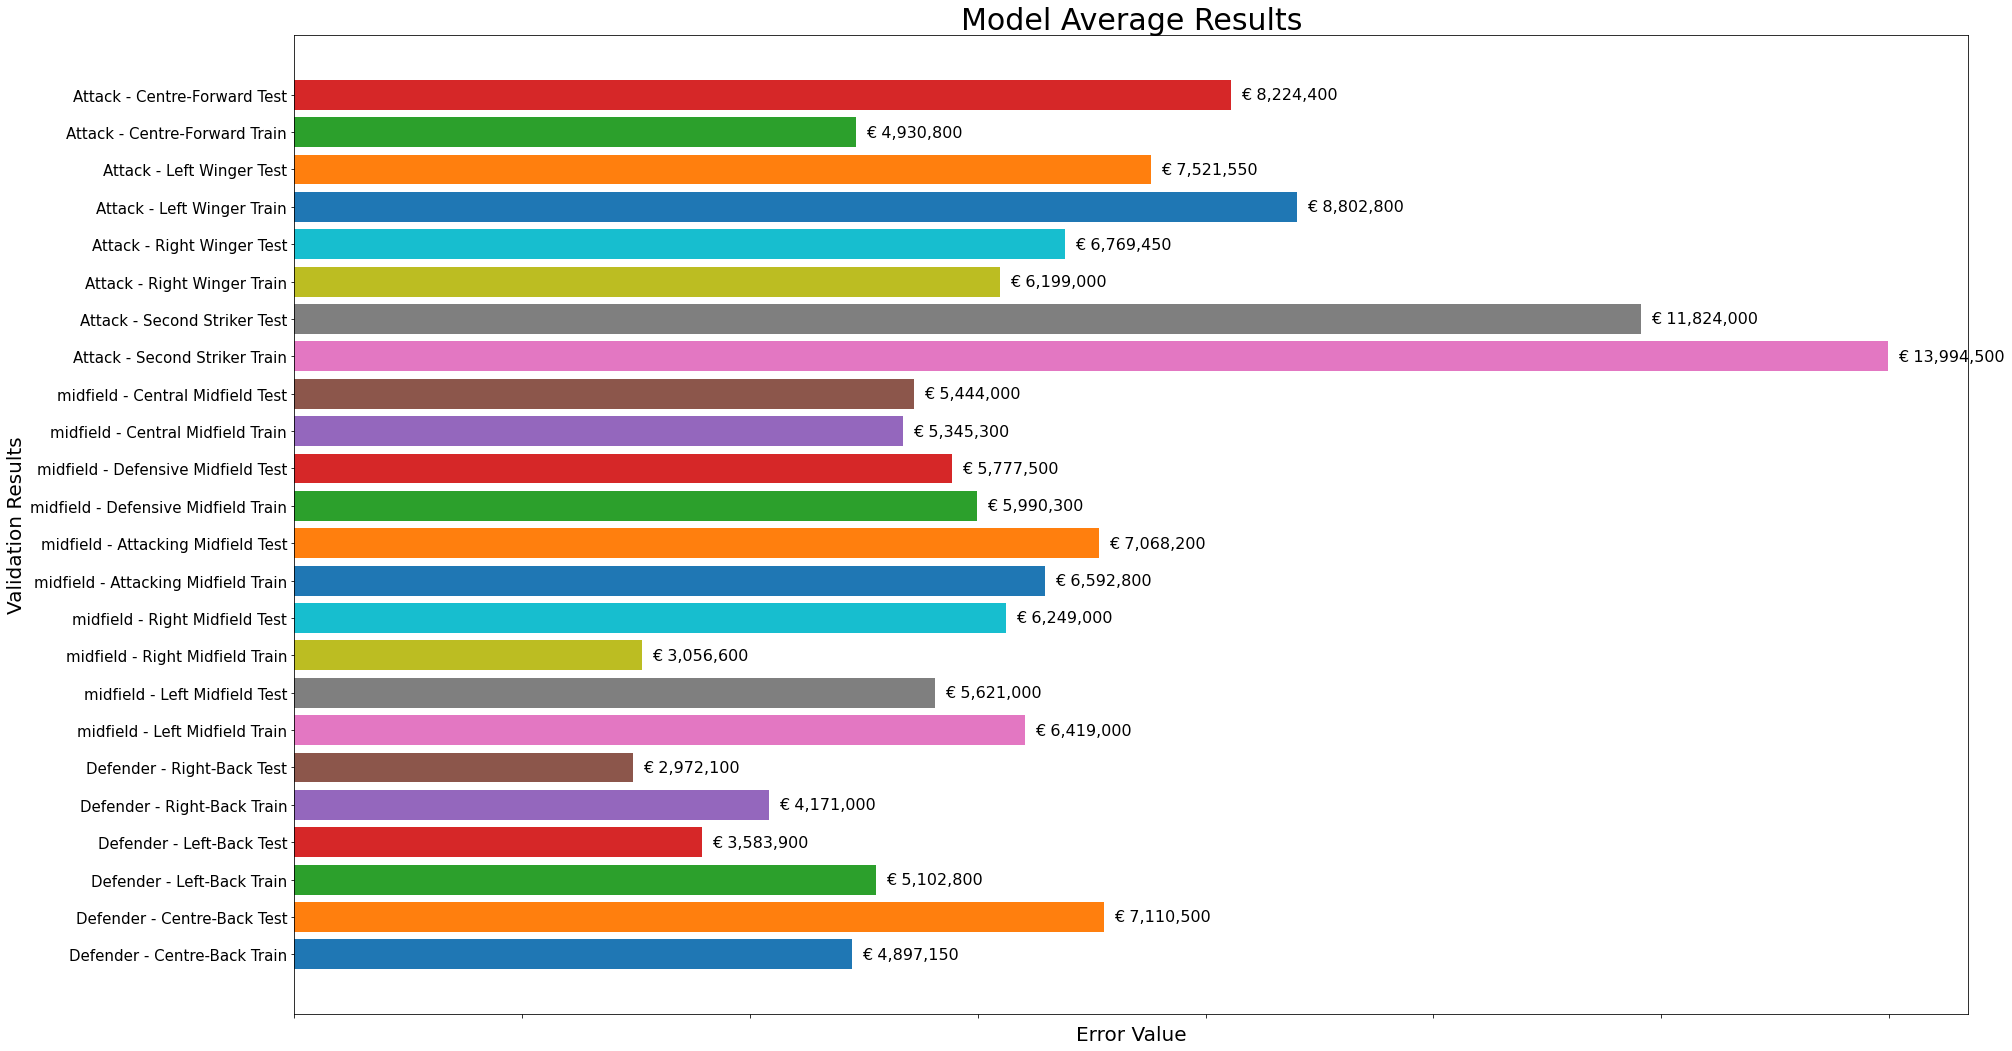

In [387]:
rf_results_each = model(all_position_dict, rf)
make_res_plot(rf_results_each, all_position_dict.keys())

### RandomForest without specified position

C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


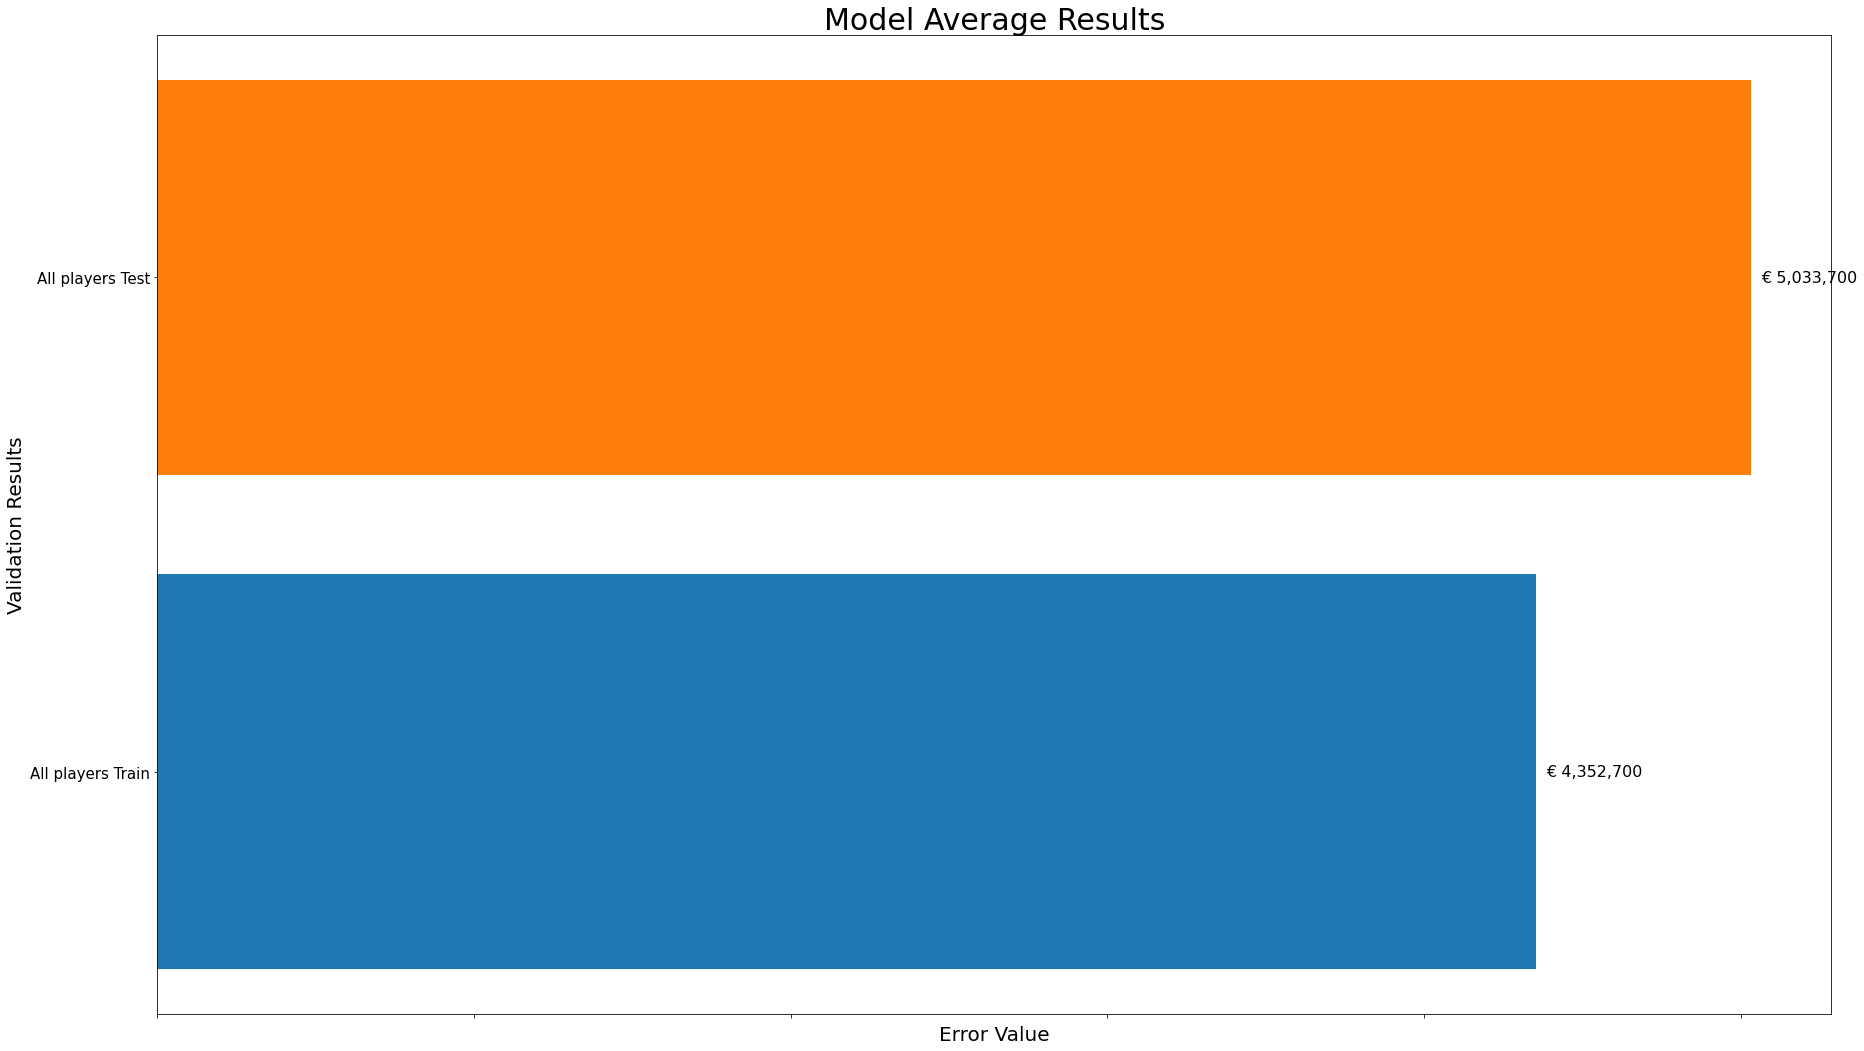

In [388]:
rf_results_np = model(non_grouped_position_dict, rf)
make_res_plot(rf_results_np, non_grouped_position_dict.keys())

## DecisionTree

In [390]:
from sklearn.tree import DecisionTreeRegressor


DtReg = DecisionTreeRegressor()

### DecisionTree for grouped positions


C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


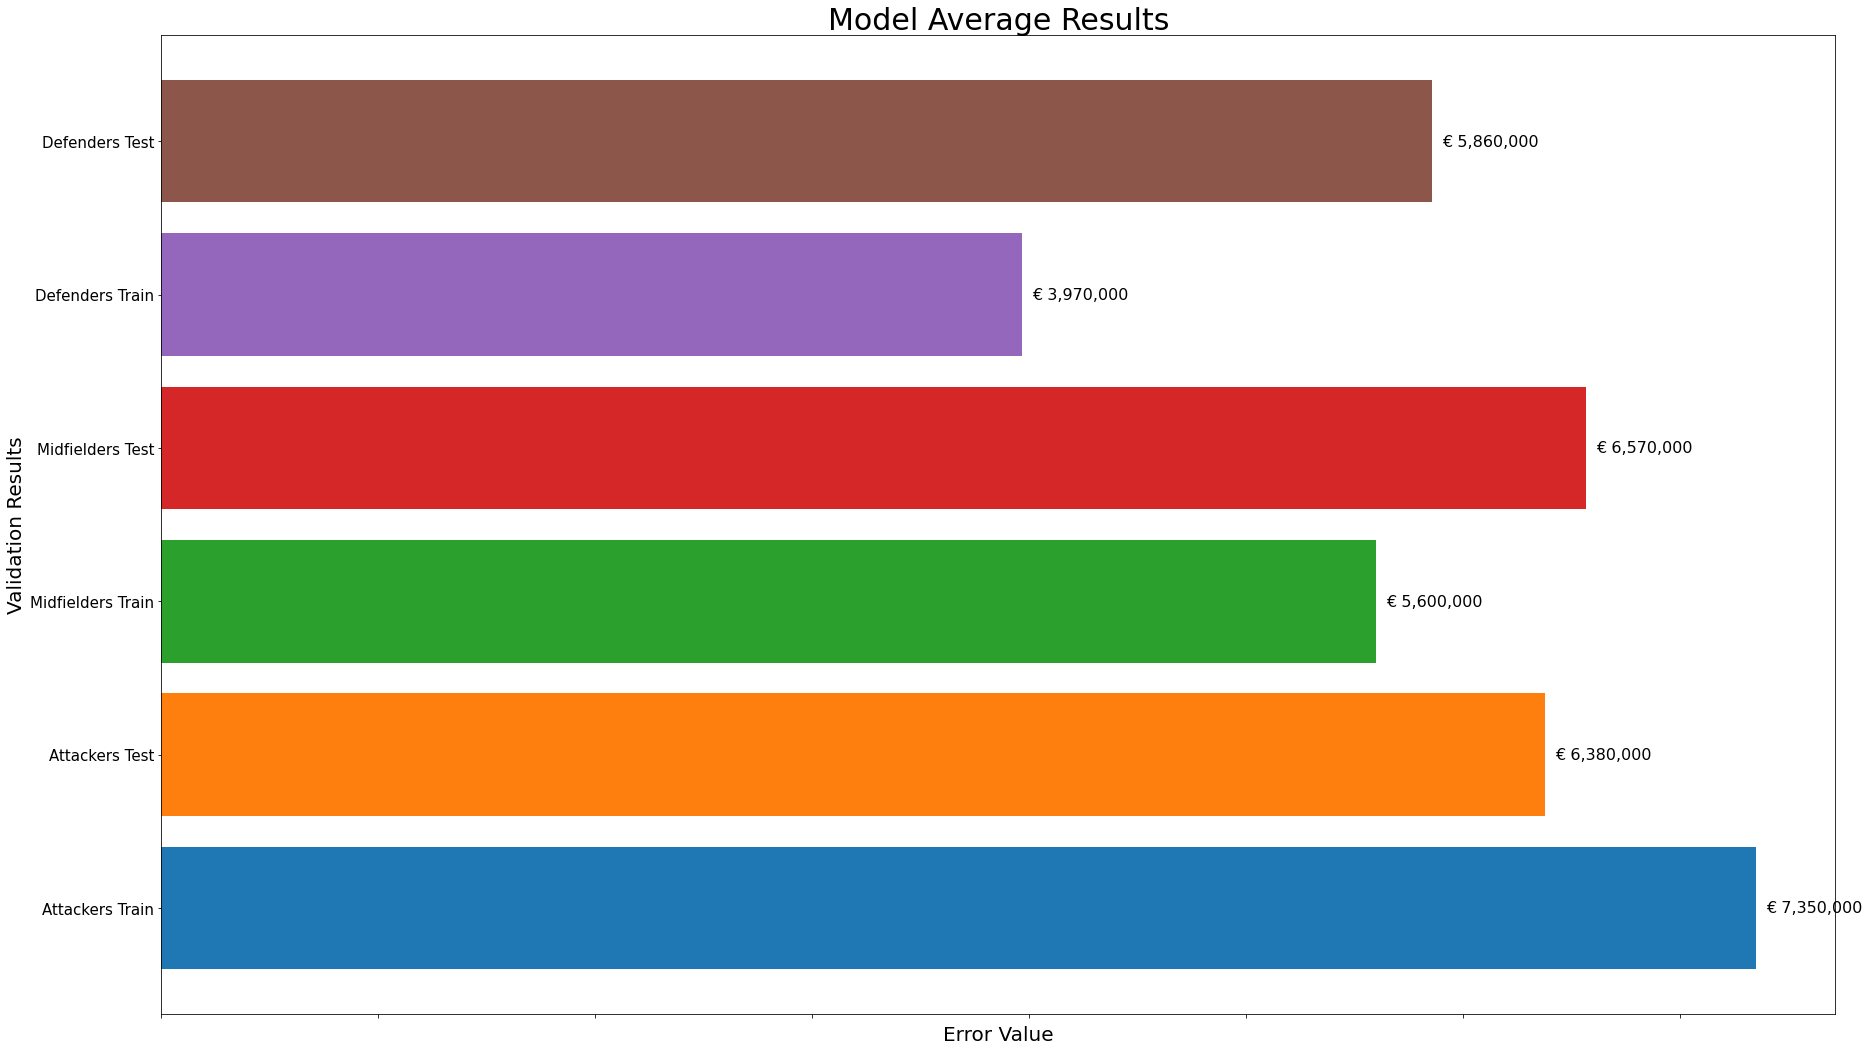

In [393]:
DtReg_results_gr = model(grouped_position_dict, DtReg)
make_res_plot(DtReg_results_gr, grouped_position_dict.keys())

### DecisionTree for each position

C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


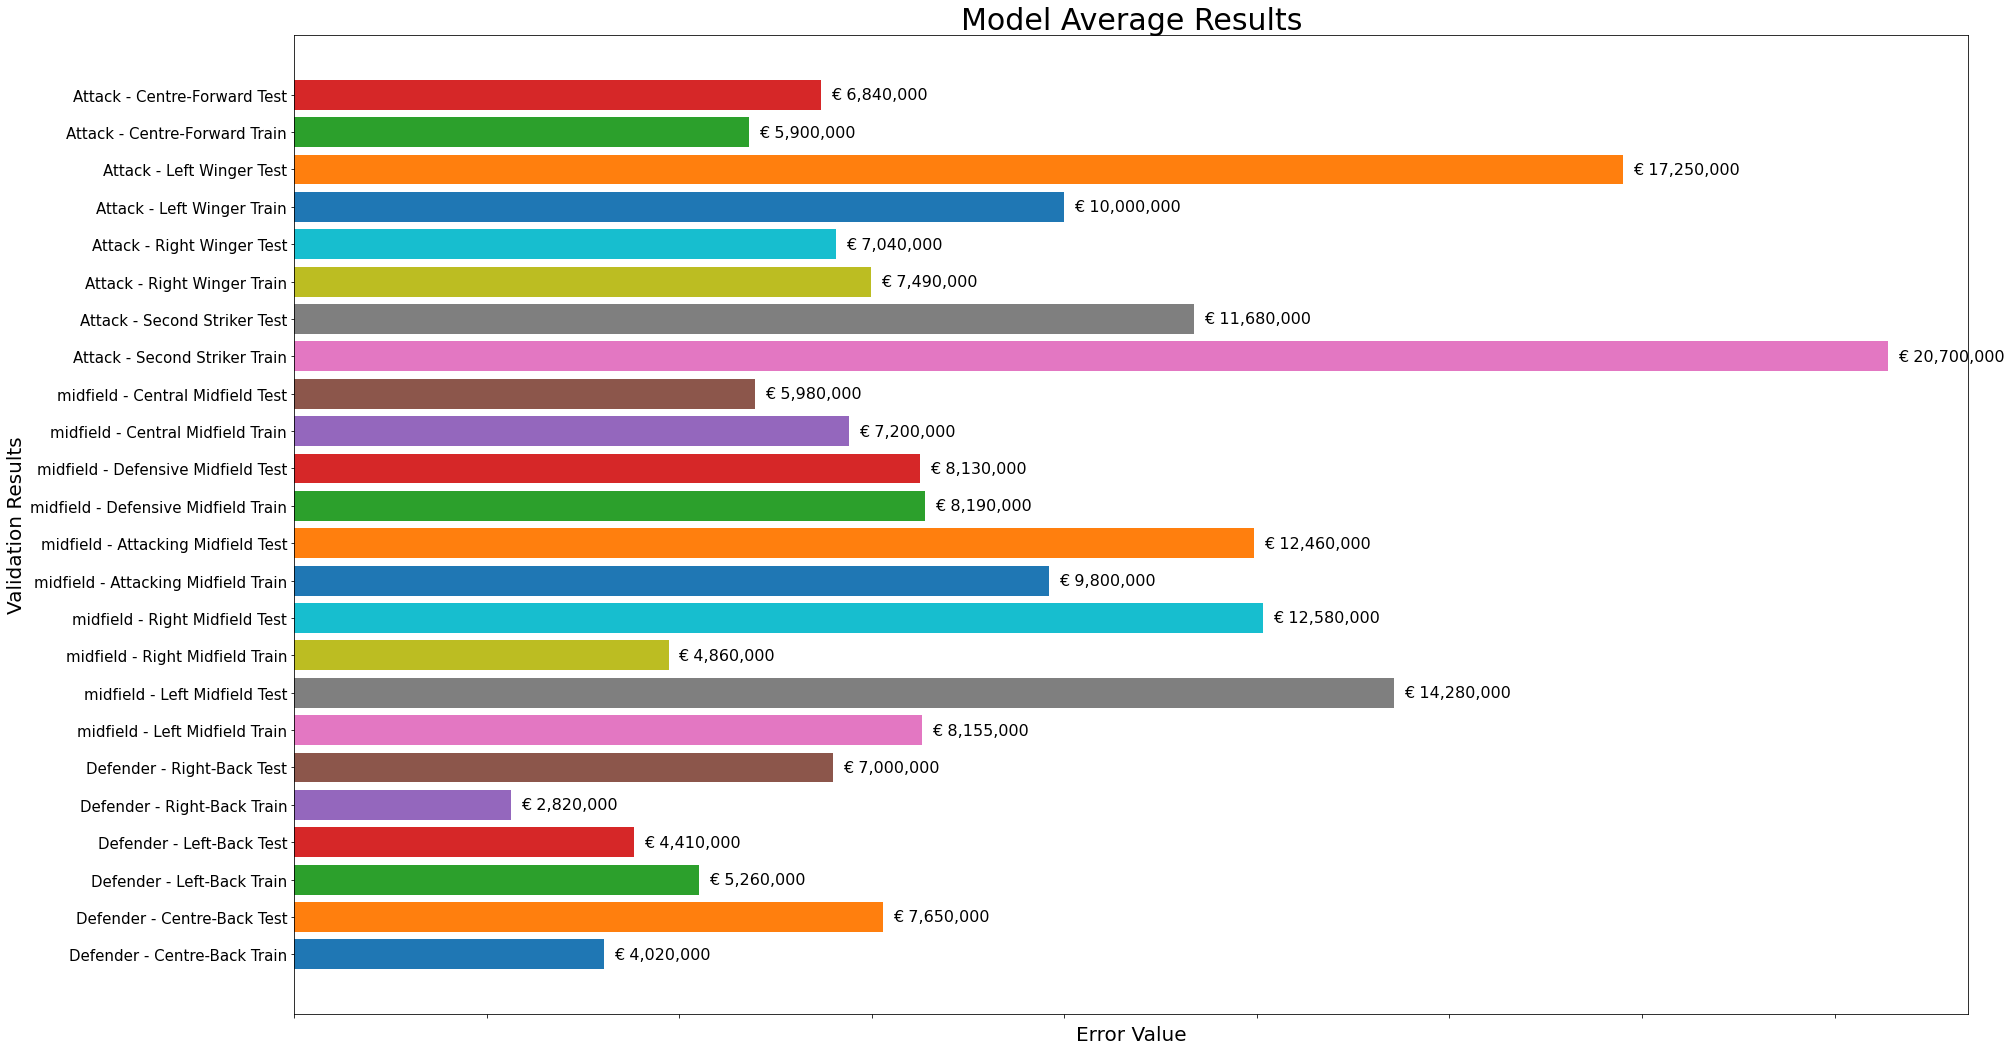

In [394]:
DtReg_results_each = model(all_position_dict, DtReg)
make_res_plot(DtReg_results_each, all_position_dict.keys())

### DecisionTree without specified position

C:\Users\vegas\AppData\Local\Temp\ipykernel_27184\994708979.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


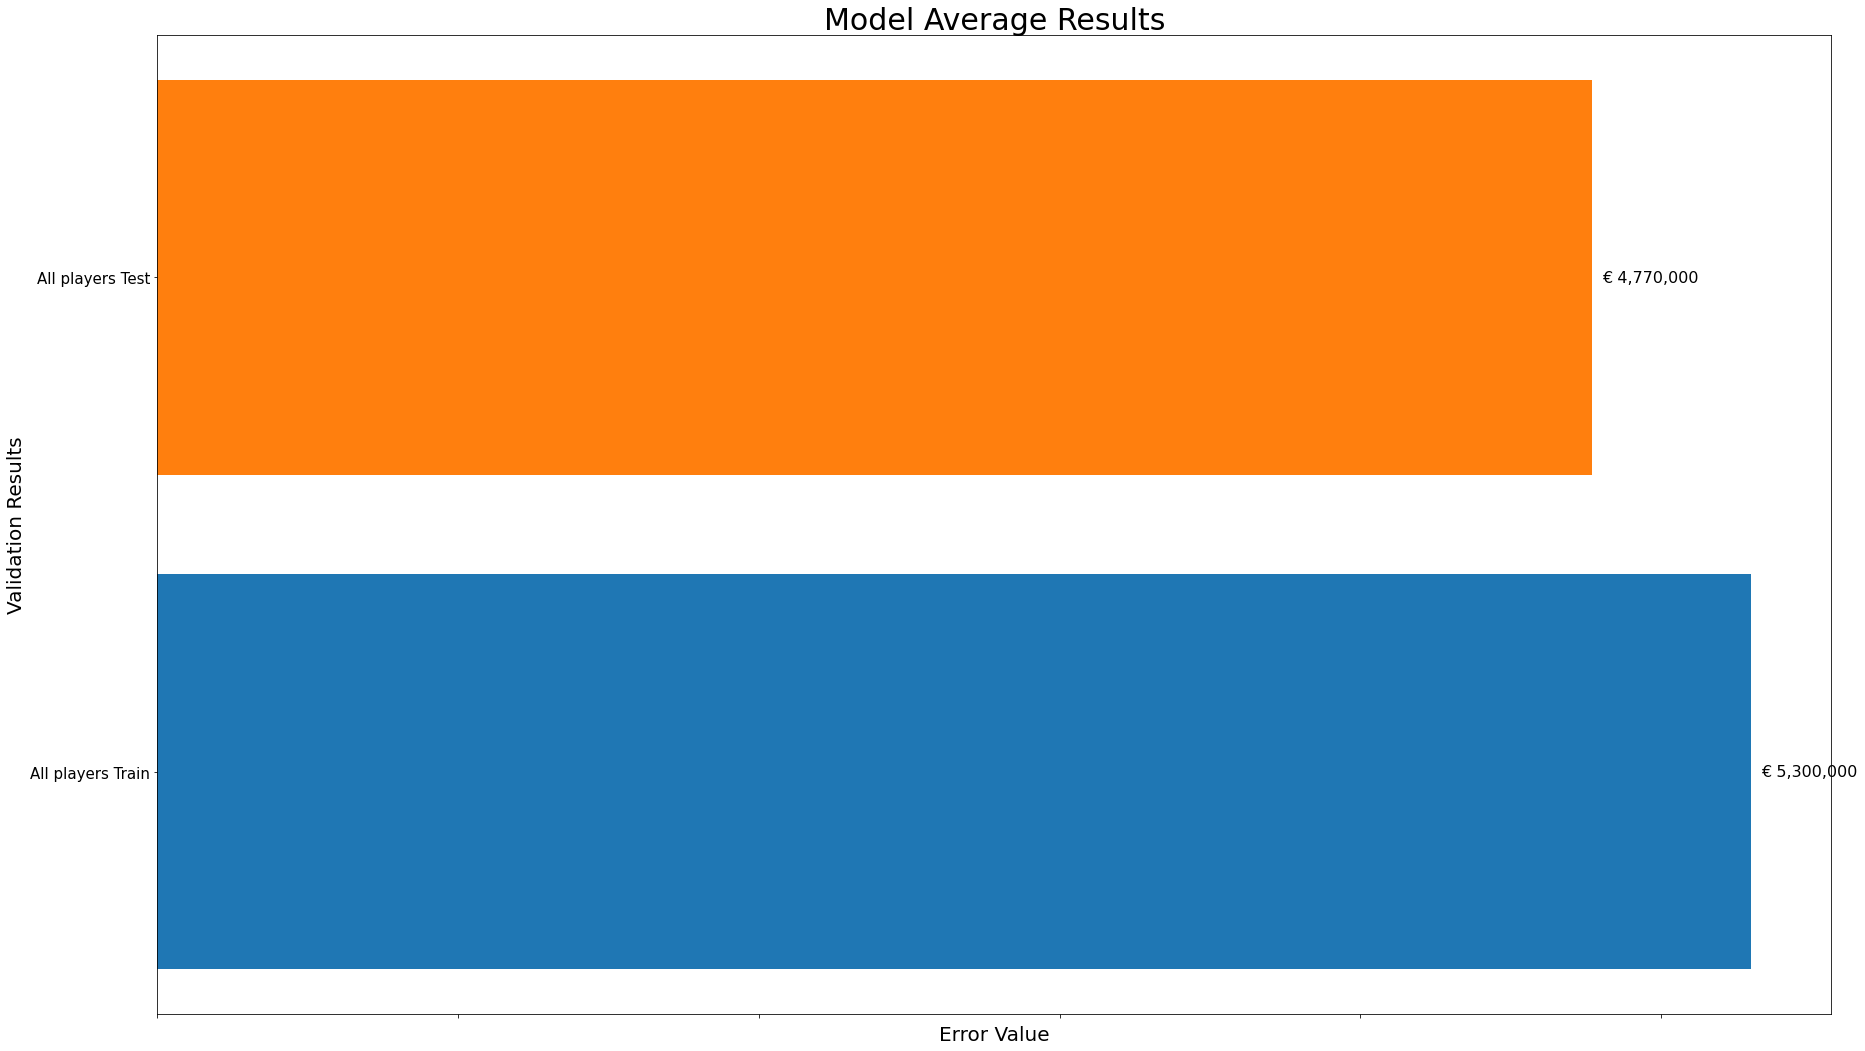

In [395]:
DtReg_results_np = model(non_grouped_position_dict, DtReg)
make_res_plot(DtReg_results_np, non_grouped_position_dict.keys())

## Comparing models

In [396]:
x_labels = ['Linear regression', 'Lasso regression', 'Ridge regression', 'AdaBoost', 'GradientBoost', 'RandomForest', 'DecisionTree']

In [397]:
import matplotlib.pyplot as plt

def visualiseModelsPerf(model_results, positions):
    fig, axs = plt.subplots(len(positions), 1, figsize=(12, 8 * len(positions)))
    for i, position in enumerate(positions):
        ax = axs[i] if len(positions) > 1 else axs

        test_errors = []
        for model_result in model_results:
            position_results = model_result[model_result['Train/Test'].str.contains(position)]
            test_error = position_results['Avg'].values[1] / 1000000
            test_errors.append(test_error)

        ax.bar(range(1, len(test_errors) + 1), test_errors, color='orange')
        ax.set_xticks(range(1, len(test_errors) + 1))
        ax.set_xticklabels(x_labels, fontsize=12, rotation=45)
        
        ax.set_xlabel('Model', fontsize=14)
        ax.set_ylabel('Test Error (in Millions €)', fontsize=14)
        ax.set_title(f'{position} Test Error Results', fontsize=16)

    plt.tight_layout()
    plt.show()


### Grouped positions

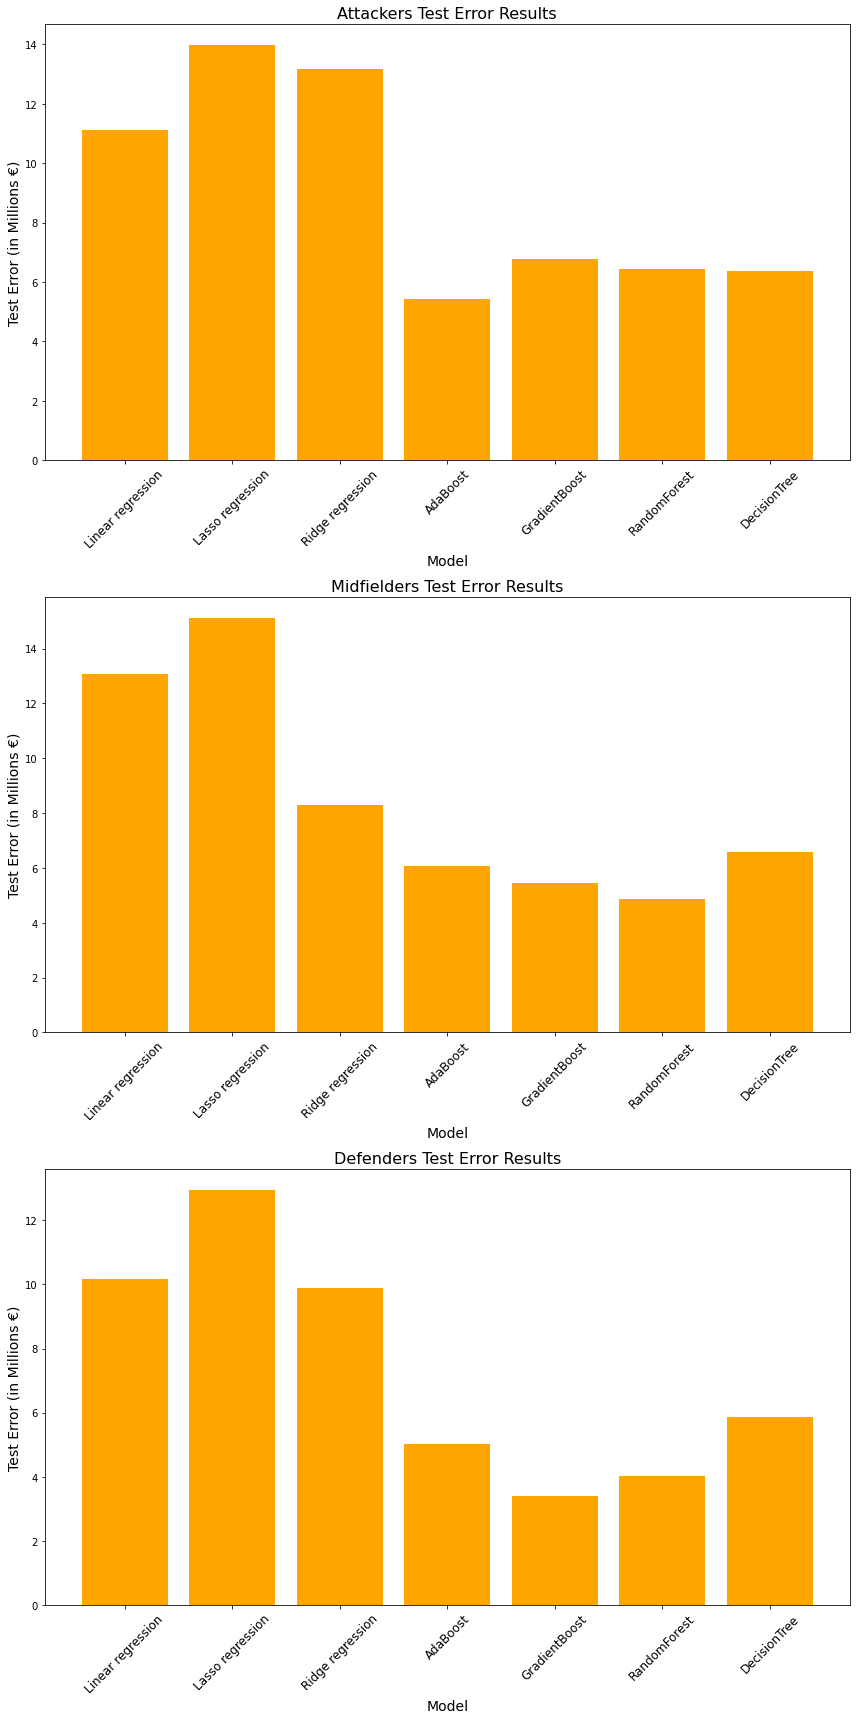

In [398]:
gr_results = [lr_results_gr,la_results_gr,rid_results_gr,ada_results_gr,gbt_results_gr,rf_results_gr,DtReg_results_gr]
visualiseModelsPerf(gr_results, grouped_position_dict.keys())

### All positions

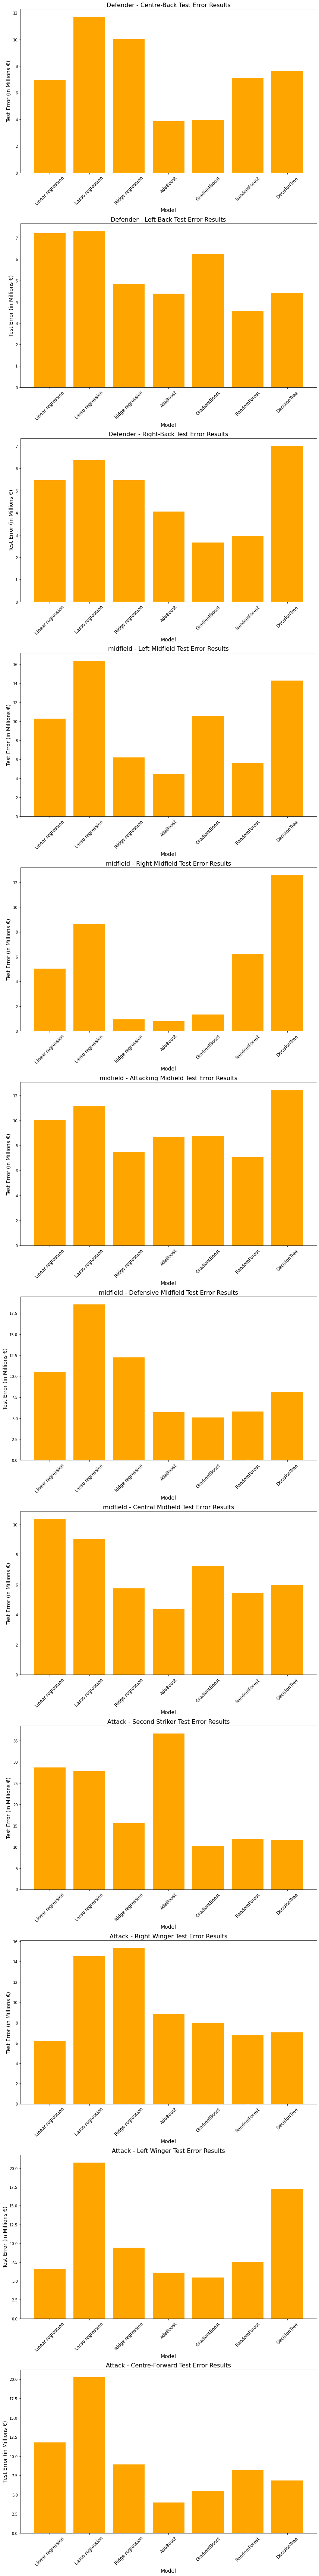

In [399]:
each_results = [lr_results_each,la_results_each,rid_results_each,ada_results_each,gbt_results_each,rf_results_each,DtReg_results_each]
visualiseModelsPerf(each_results, all_position_dict.keys())

### No positions

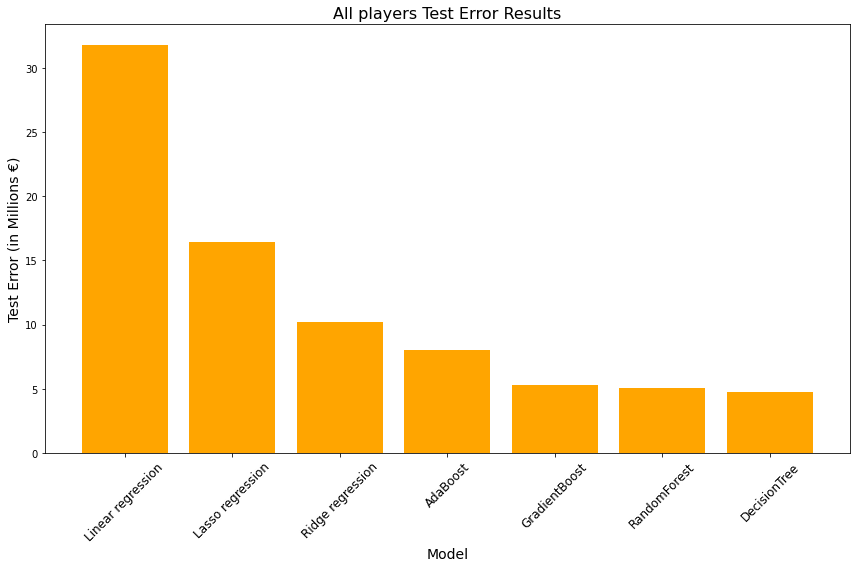

In [400]:
np_results = [lr_results_np,la_results_np,rid_results_np,ada_results_np,gbt_results_np,rf_results_np,DtReg_results_np]
visualiseModelsPerf(np_results, non_grouped_position_dict.keys())